In [1]:
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt # библиотека для построения графиков
import seaborn as sns # библиотека для построения графиков
%matplotlib inline 

In [2]:
from Bio import Entrez
from Bio import SeqIO
from time import sleep
from datetime import date

In [3]:
import csv
from ete3 import NCBITaxa

In [4]:
import itertools
import bioframe as bf
import bioframe.vis

In [5]:
from scipy.stats import fisher_exact
from statsmodels.stats.contingency_tables import mcnemar

In [6]:
## https://github.com/LankyCyril/pyvenn/blob/master/pyvenn-demo.ipynb
from venn import venn

In [7]:
import session_info

In [9]:
gc.collect()

15

# Read the data

* At first we are going to read the data about the contigs assembled from the transcriptomic samples (on per-project basis), that were left unannotated with BLASTn. They were annotated with BLASTx.

In [10]:
data = pd.read_csv('df_trx_taxi_taxo.tsv', sep='\t', index_col = 0)

In [11]:
data = data.rename(columns={ "blcol3" : "pident", 
                             "blcol4" : "length",
                         "blcol5" : "mismatch",
                         "blcol6" : "gapopen",
                         "blcol7" : "qstart",
                         "blcol8" : "qend",
                         "blcol9" : "sstart",
                         "blcol10" : "send",
                         "blcol11" : "evalue",
                         "blcol12" : "bitscore",
                         "node" : "qseqid"})

* And now we are going to read the data about the contigs assembled from the genomic samples (by project), that were left unannotated with BLASTn. They were also annotated with BLASTx.

In [12]:
datag = pd.read_csv('df_gen_taxi_taxo.tsv', sep = '\t', index_col = 0)

In [13]:
datag = datag.rename(columns={ "blcol3" : "pident", 
                           "blcol4" : "length",
                         "blcol5" : "mismatch",
                         "blcol6" : "gapopen",
                         "blcol7" : "qstart",
                         "blcol8" : "qend",
                         "blcol9" : "sstart",
                         "blcol10" : "send",
                         "blcol11" : "evalue",
                         "blcol12" : "bitscore",
                         "node" : "qseqid"})

In [14]:
datag['data_type'] = 'gen'
data['data_type'] = 'trx'

* And finally we are going to read the data about the contigs that were annotated with BLASTn as viral contigs, and then they were annotated with BLASTx.

In [15]:
datan = pd.read_csv('blastn_contigs_mapped_to_viral_with_blastn_against_nt.blastx.nr.csv', sep = '\t', header = None)

In [16]:
datan#.columns

,0,1,2,3,4,5,6,7,8,9,10,11
0,NODE_1247_length_7960_cov_25.421758,RVE41082.1,52.950,678,300,7,7539,5533,343,1010,0.000000e+00,658.0
1,NODE_1247_length_7960_cov_25.421758,VEN55040.1,50.653,689,304,7,7539,5533,268,940,0.000000e+00,642.0
2,NODE_1247_length_7960_cov_25.421758,XP_014261397.2,51.420,669,304,8,7539,5539,112,761,0.000000e+00,625.0
3,NODE_1247_length_7960_cov_25.421758,OWR44608.1,49.202,689,311,5,7539,5539,174,845,0.000000e+00,624.0
4,NODE_1247_length_7960_cov_25.421758,XP_028152957.1,49.444,720,321,9,7635,5545,178,877,0.000000e+00,624.0
...,...,...,...,...,...,...,...,...,...,...,...,...
436412,NODE_7_length_8456_cov_102.553029,QGH51259.1,48.266,1096,543,9,2707,5955,1089,2173,0.000000e+00,988.0
436413,NODE_7_length_8456_cov_102.553029,QGH51259.1,42.792,437,244,3,37,1329,1,437,1.350000e-92,350.0
436414,NODE_7_length_8456_cov_102.553029,QGH51259.1,21.264,174,133,1,2059,2568,684,857,9.000000e-03,55.1
436415,NODE_7_length_8456_cov_102.553029,ADT91615.1,48.584,1095,539,9,2707,5952,1093,2176,0.000000e+00,988.0


In [17]:
datan.columns = ['qseqid', 'caption_x', 'pident', 'length', 'mismatch', 'gapopen',
                 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [18]:
datan.head()

,qseqid,caption_x,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,NODE_1247_length_7960_cov_25.421758,RVE41082.1,52.950,678,300,7,7539,5533,343,1010,0.0,658.0
1,NODE_1247_length_7960_cov_25.421758,VEN55040.1,50.653,689,304,7,7539,5533,268,940,0.0,642.0
2,NODE_1247_length_7960_cov_25.421758,XP_014261397.2,51.420,669,304,8,7539,5539,112,761,0.0,625.0
3,NODE_1247_length_7960_cov_25.421758,OWR44608.1,49.202,689,311,5,7539,5539,174,845,0.0,624.0
4,NODE_1247_length_7960_cov_25.421758,XP_028152957.1,49.444,720,321,9,7635,5545,178,877,0.0,624.0


* Read the taxonomy annotation for BLASTn hits (for virus-positive contigs)

In [19]:
datan_tax = pd.read_csv('blastn_viral.taxonomy.csv', index_col =0)

In [20]:
datan_tax.head()

,taxid,kindom,phylum,class,order,family,genus,species,GeneID,Title,TaxId,Caption
0,100035,Eukaryota,Ascomycota,Dothideomycetes,Pleosporales,NaN,Massariosphaeria,Massariosphaeria phaeospora,1812399247,RlpA-like double-psi beta-barrel-protein domai...,100035,KAF2865109
1,100035,Eukaryota,Ascomycota,Dothideomycetes,Pleosporales,NaN,Massariosphaeria,Massariosphaeria phaeospora,1812410659,hypothetical protein BDV95DRAFT_560786 [Massar...,100035,KAF2876477
2,1000413,Eukaryota,Streptophyta,Magnoliopsida,Sapindales,Sapindaceae,Acer,Acer yangbiense,1725300549,hypothetical protein EZV62_027900 [Acer yangbi...,1000413,TXG46600
3,1000413,Eukaryota,Streptophyta,Magnoliopsida,Sapindales,Sapindaceae,Acer,Acer yangbiense,1725307860,hypothetical protein EZV62_019115 [Acer yangbi...,1000413,TXG53859
4,1000413,Eukaryota,Streptophyta,Magnoliopsida,Sapindales,Sapindaceae,Acer,Acer yangbiense,1725311956,hypothetical protein EZV62_015782 [Acer yangbi...,1000413,TXG57953


In [21]:
#datan_tax.head()
datan_tax.drop(columns = 'TaxId', inplace = True)

In [22]:
datan_tax.columns = datan_tax.columns.str.lower()

In [23]:
datan['caption'] = datan.caption_x.str.replace('\.\d+','', regex = True)

In [24]:
## merge the tables with BLASTn results 
datan2 = datan.merge(datan_tax, on = 'caption', how = 'left')

In [25]:
datan2 = datan2.rename(columns = {'caption':'Caption',
                                  'geneid' :'genid'})

In [26]:
datan2['data_type'] = 'blastn'

In [27]:
datan2.shape, datag.shape, data.shape
# ((436417, 24), (4328532, 25), (1417959, 25))

((436417, 24), (4328532, 25), (1417959, 25))

In [28]:
datan2['caption_y'] = datan2.caption_x.values

In [29]:
datan2.columns

Index(['qseqid', 'caption_x', 'pident', 'length', 'mismatch', 'gapopen',
       'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'Caption',
       'taxid', 'kindom', 'phylum', 'class', 'order', 'family', 'genus',
       'species', 'genid', 'title', 'data_type', 'caption_y'],
      dtype='object')

In [94]:
#pd.DataFrame({0:datan2.columns.sort_values(),
#              1:data.columns.sort_values(),
#              2:datag.columns.sort_values()})

In [30]:
set(datag.columns) - set(data.columns), set(datan2.columns) - set(datag.columns), set(datag.columns) - set(datan2.columns)

(set(), set(), set())

* Make the combined table

In [31]:
datac = pd.concat([ data.reset_index(drop = True),
            datag[data.columns].reset_index(drop = True),
            datan2[data.columns].reset_index(drop = True) ] , axis = 0, ignore_index = True) 

In [32]:
datac.shape, data.shape, datag.shape, datac.shape[0] == data.shape[0] + datag.shape[0]
# ((6182908, 25), (1417959, 25), (4328532, 25), False)

((6182908, 25), (1417959, 25), (4328532, 25), False)

* Read the data about the projects (from NCBI SRA)

In [33]:
proj = pd.read_csv('contigs_id_projects.csv')

In [34]:
proj.project.unique()

array(['PRJNA171749', 'PRJNA275431', 'PRJNA275662', 'PRJNA280017',
       'PRJNA297027', 'PRJNA336167', 'PRJNA353242', 'PRJNA369863',
       'PRJNA384383', 'PRJNA400685_head', 'PRJNA400685_midgut',
       'PRJNA438159', 'PRJNA464380', 'PRJNA553565', 'PRJNA580490',
       'PRJNA646009', 'PRJNA694179'], dtype=object)

In [35]:
datacp = datac.merge( proj , on = 'qseqid', how = 'left')

In [36]:
datacp.project.unique()

array(['PRJNA353242', 'PRJNA275431', 'PRJNA275662', 'PRJNA297027',
       'PRJNA438159', 'PRJNA464380', 'PRJNA553565', 'PRJNA280017',
       'PRJNA336167', 'PRJNA400685_midgut', 'PRJNA646009', nan,
       'PRJNA694179', 'PRJNA400685_head', 'PRJNA171749', 'PRJNA580490',
       'PRJNA384383'], dtype=object)

In [37]:
## fill in the missed 'Project ID' values
datacp.project.fillna('PRJNA369863+PRJNA508767', inplace = True)

In [38]:
datacp.shape

(6182908, 26)

In [39]:
data.shape

(1417959, 25)

In [41]:
datacp['Caption'] = datacp.Caption.str.replace('^[a-z]+\|','', regex = True).str.replace('\|','', regex = True)

* check if there are records with empty TaxId values

In [42]:
unk_tax = datacp[['Caption','taxid']].drop_duplicates()
#.taxid.isna().sum()
unk_tax[unk_tax.taxid.isna()]

,Caption,taxid
5747061,NBX97749,NaN
5747062,NCY23553,NaN
5747091,CAD7478650,NaN
5747120,HBK84078,NaN
5747255,S00954,NaN
...,...,...
6164254,NXX50479,NaN
6164255,NWS41339,NaN
6165181,CAF4778013,NaN
6165185,CAF4777995,NaN


In [43]:
datacp[datacp.Caption == 'CAD7478650'].iloc[0]

qseqid                   NODE_14_length_4005_cov_32.767342
caption_x                                     CAD7478650.1
pident                                              31.966
length                                                 951
mismatch                                               555
gapopen                                                 23
qstart                                                3457
qend                                                   809
sstart                                                  50
send                                                   976
evalue                                                 0.0
bitscore                                             474.0
Caption                                         CAD7478650
genid                                         1966992545.0
title        unnamed protein product [Plutella xylostella]
taxid                                              51655.0
caption_y                                       CAD74786

* The best solution to complete the annotation was to extract the corresponding information from GenBank. We used Biopython interface to NCBI eUtils. All the records were downloaded by small chunks (of 200 records). When the data was downloaded, we used __*ete3*__ _**NCBITaxa**_ to fill in the missed taxonomy annotation.

In [44]:
idlist = unk_tax[unk_tax.taxid.isna()].Caption.unique().tolist()

In [45]:
len(idlist)

10484

In [46]:
## make chunks for quering Entrez
idchunks = [ idlist[i:i+200] for i in range(len(idlist)) if i%200 == 0 ]

In [47]:
#len(sum(idchunks, []) )
len(idchunks)

53

In [67]:
## To download the records uncomment and run the code below
#Entrez.email = "my@email.com" ## provide your valid e-mail here or leave commented
#
#for i in range(len(idchunks)):
#    handle = Entrez.efetch(db="protein",
#                           id=idchunks[i],
#                           rettype="gb",
#                           retmode="text")
#    #whole_sequence = SeqIO.read(handle, "genbank")
#    out_handle = open('GenPept_unk_tax.gp', "a")
#    out_handle.write(handle.read()+'\n')
#    out_handle.flush()
#    out_handle.close()
#    handle.close()
#    print (f'{i} - done!')
#    sleep(3)

0 - done!
1 - done!
2 - done!
3 - done!
4 - done!
5 - done!
6 - done!
7 - done!
8 - done!
9 - done!
10 - done!
11 - done!
12 - done!
13 - done!
14 - done!
15 - done!
16 - done!
17 - done!
18 - done!
19 - done!
20 - done!
21 - done!
22 - done!
23 - done!
24 - done!
25 - done!
26 - done!
27 - done!
28 - done!
29 - done!
30 - done!
31 - done!
32 - done!
33 - done!
34 - done!
35 - done!
36 - done!
37 - done!
38 - done!
39 - done!
40 - done!
41 - done!
42 - done!
43 - done!
44 - done!
45 - done!
46 - done!
47 - done!
48 - done!
49 - done!
50 - done!
51 - done!
52 - done!


In [48]:
f = open('GenPept_unk_tax.gp')
unk_seq = list( SeqIO.parse(f, 'genbank') )
f.close()

Extract the TaxId and annotation for unannotated proteins

In [49]:
#record = unk_seq[100]
def get_info(record):
    try:
        for feature in record.features:
            if feature.type == 'source':
                taxid = feature.qualifiers["db_xref"][0].strip('taxon:')
                orgn  = feature.qualifiers["organism"][0].strip()
        return (pd.Series([record.id, record.name, record.description, taxid, orgn],
                      index = ['id', 'Caption', 'title', 'taxid', 'organism']))
    except:
        print (record.id)
        return pd.Series([record.id, record.name, record.description, '', ''],
                      index = ['id', 'Caption', 'title', 'taxid', 'organism'])

In [50]:
unk_seq_df = pd.DataFrame( [get_info(x) for x in unk_seq] )

I38588.1


In [51]:
unk_seq_df.head()

,id,Caption,title,taxid,organism
0,NBX97749.1,NBX97749,"MAG: hypothetical protein EBQ81_02685, partial...",1869227,bacterium
1,NCY23553.1,NCY23553,MAG: hypothetical protein EBX37_01460 [Alphapr...,1913988,Alphaproteobacteria bacterium
2,CAD7478650.1,CAD7478650,unnamed protein product [Plutella xylostella],51655,Plutella xylostella
3,HBK84078.1,HBK84078,"MAG TPA: hypothetical protein DDZ41_10880, par...",239,Flavobacterium sp.
4,S00954,S00954,pol polyprotein - fruit fly (Drosophila melano...,7227,Drosophila melanogaster


In [52]:
unk_seq_df = unk_seq_df[unk_seq_df.taxid != '']

In [53]:
## NB! If you didn't use ete3.NCBITaxa this cell could take a long time...
ncbi = NCBITaxa()


In [54]:
## from https://stackoverflow.com/questions/43867631
## the function to get the desired taxonomic ranks by TaxId
def get_desired_ranks(taxid, desired_ranks):
    lineage = ncbi.get_lineage(taxid)   
    names = ncbi.get_taxid_translator(lineage)
    lineage2ranks = ncbi.get_rank(names)
    ranks2lineage = dict((rank,taxid) for (taxid, rank) in lineage2ranks.items())
    return{'{}_id'.format(rank): ranks2lineage.get(rank, '') for rank in desired_ranks}


In [55]:
#taxids = ['1204725', '2162',  '1300163', '420247']
taxids = unk_seq_df.taxid.unique()

In [56]:
len(taxids)

794

Extract the taxonomy for unannotated proteins

In [57]:
desired_ranks = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
results = list()
for taxid in taxids:
    results.append(list())
    results[-1].append(str(taxid))
    ranks = get_desired_ranks(taxid, desired_ranks)
    for key, rank in ranks.items():
        if rank != '':
            results[-1].append(list(ncbi.get_taxid_translator([rank]).values())[0])
        else:
            results[-1].append(rank)

#generate the header
header = ['taxid']
header.extend(desired_ranks)
#print('\t'.join(header))
#print the results
#for result in results:
#    print('\t'.join(result))

C:\Users\Sammael\anaconda3\envs\geo_env\lib\site-packages\ete3\ncbi_taxonomy\ncbiquery.py:243: UserWarning: taxid 93930 was translated into 93929
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [58]:
unk_seq_df_tax = pd.DataFrame( results , columns = header)

In [59]:
unk_seq_df_tax.head()

,taxid,superkingdom,phylum,class,order,family,genus,species
0,1869227,Bacteria,,,,,,bacterium
1,1913988,Bacteria,Proteobacteria,Alphaproteobacteria,,,,Alphaproteobacteria bacterium
2,51655,Eukaryota,Arthropoda,Insecta,Lepidoptera,Plutellidae,Plutella,Plutella xylostella
3,239,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,Flavobacterium sp.
4,7227,Eukaryota,Arthropoda,Insecta,Diptera,Drosophilidae,Drosophila,Drosophila melanogaster


Merge the tables with the taxonomy and annotation

In [60]:
unk_seq_df_anno = unk_seq_df.merge( unk_seq_df_tax, on = 'taxid')

In [61]:
unk_seq_df_anno = unk_seq_df_anno.rename(columns = {'superkingdom' : 'kindom'})

foo = unk_seq_df_anno.merge( datacp , on = 'Caption')

#foo.columns
foo2 = foo.drop(columns = ['id', 'title_y', 'taxid_y', 'kindom_y', 'phylum_y', 'class_y',
       'order_y', 'family_y', 'genus_y', 'species_y','organism']).rename(
    columns = dict( zip(['title_x', 'taxid_x', 'kindom_x', 'phylum_x', 'class_x',
                         'order_x', 'family_x', 'genus_x', 'species_x'],
                        ['title', 'taxid', 'kindom', 'phylum', 'class',
                         'order', 'family', 'genus', 'species'])))

## merge the tables datacp and unk_seq_df_anno 
datacp_upd = pd.concat( [datacp[~datacp.taxid.isna()], foo2[datacp.columns] ] )

In [62]:
datacp.shape, datacp[~datacp.taxid.isna()].shape, datacp_upd.shape
# ((6182908, 26), (6167071, 26), (6200054, 26))

((6182908, 26), (6167071, 26), (6200054, 26))

In [63]:
#data.head(3)
datacp_upd

,qseqid,caption_x,pident,length,mismatch,gapopen,qstart,qend,sstart,send,...,caption_y,kindom,phylum,class,order,family,genus,species,data_type,project
0,NODE_125_length_10672_cov_442.064990,QMP82151.1,30.959,1502,985,17,6635,2175,2,1466,...,QMP82151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trx,PRJNA353242
1,NODE_125_length_10672_cov_442.064990,QMP82151.1,31.492,181,102,9,1451,939,1642,1810,...,QMP82151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trx,PRJNA353242
2,NODE_1_length_14482_cov_858.024121,QMP82151.1,29.326,1930,1212,38,6614,918,2,1810,...,QMP82151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trx,PRJNA275431
3,NODE_1_length_14486_cov_119.472039,QMP82151.1,30.892,1502,986,17,6611,2151,2,1466,...,QMP82151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trx,PRJNA275662
4,NODE_1_length_14486_cov_119.472039,QMP82151.1,31.492,181,102,9,1427,915,1642,1810,...,QMP82151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trx,PRJNA275662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32978,NODE_5_length_9243_cov_35.070309,EBW8678369.1,79.721,646,128,2,6539,8470,1,645,...,EBW8678369.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica,blastn,PRJNA580490
32979,NODE_5_length_9243_cov_35.070309,EED8542953.1,79.567,646,129,2,6539,8470,1,645,...,EED8542953.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica,blastn,PRJNA580490
32980,NODE_48828_length_752_cov_24.467719,EHE7993299.1,96.748,246,8,0,3,740,172,417,...,EHE7993299.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica,blastn,PRJNA580490
32981,NODE_48828_length_752_cov_24.467719,MPT44601.1,90.688,247,23,0,3,743,172,418,...,MPT44601.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella sp.,blastn,PRJNA580490


In [64]:
datacp['prog'] = 'blastx'

In [65]:
datacp_upd['prog'] = 'blastx'
datacp_upd.project.fillna('PRJNA369863+PRJNA508767', inplace = True)

#### NB! Check for missing TaxId and missing taxonomy to fix it...

The origin of the problem is the wrong taxid number formatting &mdash; it should be checked!!!!!

In [66]:
## there are no empty taxids in the data but the problems are still there... 
datacp_upd.taxid.isna().sum()

0

In [67]:
## the taxonomy annotation is still not complete
## let's try to fix it
datacp_upd[['kindom', 'phylum', 'class',
            'order', 'family', 'genus', 'species']].isna().sum()

kindom     4158293
phylum     4200430
class      4218820
order      4221332
family     4209095
genus      4210081
species    4160533
dtype: int64

In [68]:
## run to convert the TaxIds into correct form
datacp_upd['fxd_taxid'] = datacp_upd.taxid.astype(int).astype(str)

In [69]:
## extract the rows with any taxonomy rank missed
w_unktax = datacp_upd[['kindom', 'phylum', 'class',
            'order', 'family', 'genus', 'species']].isna().apply(any, axis = 1)

In [70]:
datacp_upd_unk_otu = datacp_upd[ datacp_upd[['kindom', 'phylum', 'class',
            'order', 'family', 'genus', 'species']].isna().apply(any, axis = 1) ]

In [71]:
## there is a lot of rows with missed taxonomy ranks
datacp_upd.shape, datacp_upd_unk_otu.shape
#((6200054, 28), (4251733, 28))

((6200054, 28), (4251733, 28))

In [73]:
gc.collect()

15

In [74]:
## extract the unique TaxIds
taxids = datacp_upd_unk_otu.fxd_taxid.unique()

In [75]:
taxids.size

10646

In [76]:
## try to fill in the missed taxonomy annotation
desired_ranks = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
results = list()
for taxid in taxids:
    results.append(list())
    results[-1].append(str(taxid))
    ranks = get_desired_ranks(taxid, desired_ranks)
    for key, rank in ranks.items():
        if rank != '':
            results[-1].append(list(ncbi.get_taxid_translator([rank]).values())[0])
        else:
            results[-1].append(rank)

#generate the header
header = ['taxid']
header.extend(desired_ranks)


C:\Users\Sammael\anaconda3\envs\geo_env\lib\site-packages\ete3\ncbi_taxonomy\ncbiquery.py:243: UserWarning: taxid 5400 was translated into 1973307
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
C:\Users\Sammael\anaconda3\envs\geo_env\lib\site-packages\ete3\ncbi_taxonomy\ncbiquery.py:243: UserWarning: taxid 206315 was translated into 2823264
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
C:\Users\Sammael\anaconda3\envs\geo_env\lib\site-packages\ete3\ncbi_taxonomy\ncbiquery.py:243: UserWarning: taxid 1925502 was translated into 2847850
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
C:\Users\Sammael\anaconda3\envs\geo_env\lib\site-packages\ete3\ncbi_taxonomy\ncbiquery.py:243: UserWarning: taxid 246570 was translated into 2688777
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
C:\Users\Sammael\anaconda3\envs\geo_env\lib\site-packages\ete

In [77]:
## make the dataframe with taxonomy annotation
datacp_upd_unk_otu_df_tax = pd.DataFrame( results , columns = header)

In [78]:
datacp_upd_unk_otu_df_tax.superkingdom.value_counts()

Bacteria     4411
Eukaryota    3431
Viruses      2358
Archaea       416
               30
Name: superkingdom, dtype: int64

In [79]:
datacp_upd_unk_otu_df_tax[datacp_upd_unk_otu_df_tax.family.str.endswith('viridae')].family.value_counts().head(30)

Orthomyxoviridae    518
Rhabdoviridae       147
Baculoviridae       129
Iflaviridae          92
Picornaviridae       80
Virgaviridae         74
Dicistroviridae      67
Chuviridae           45
Bromoviridae         40
Secoviridae          37
Closteroviridae      37
Salasmaviridae       34
Tectiviridae         24
Adintoviridae        22
Retroviridae         21
Microviridae         20
Lispiviridae         15
Nudiviridae          14
Phasmaviridae        14
Rountreeviridae      13
Siphoviridae         12
Nyamiviridae         12
Zierdtviridae        11
Xinmoviridae         11
Guelinviridae         9
Kitaviridae           9
Podoviridae           9
Caliciviridae         9
Parvoviridae          8
Autolykiviridae       7
Name: family, dtype: int64

In [80]:
## you should rename the columns for the compatibility with datacp table
datacp_upd_unk_otu_df_tax = datacp_upd_unk_otu_df_tax.rename(columns = {'superkingdom' : 'kindom',
                                                                        'taxid' : 'fxd_taxid'})

In [81]:
## merge the tables
datacp_upd_unk_otu_df_tax_anno = datacp_upd_unk_otu_df_tax.merge(
  datacp_upd[ w_unktax ][['Caption', 'fxd_taxid', 'title']].drop_duplicates(), on = 'fxd_taxid' )
## the datacp_upd_unk_otu_df_tax_anno is now as complete as possible...

In [82]:
gc.collect()

155

In [83]:
datacp_upd_unk_otu_df_tax_anno[datacp_upd_unk_otu_df_tax_anno['class'] == 'Insecta'].head()

,fxd_taxid,kindom,phylum,class,order,family,genus,species,Caption,title
7,76193,Eukaryota,Arthropoda,Insecta,Lepidoptera,Papilionidae,Papilio,Papilio machaon,KPJ12187,RNA-directed RNA polymerase L [Papilio machaon]
8,76193,Eukaryota,Arthropoda,Insecta,Lepidoptera,Papilionidae,Papilio,Papilio machaon,KPJ07845,GTP-binding protein CG1354 [Papilio machaon]
9,76193,Eukaryota,Arthropoda,Insecta,Lepidoptera,Papilionidae,Papilio,Papilio machaon,XP_014357830,PREDICTED: RNA-directed DNA polymerase from mo...
10,76193,Eukaryota,Arthropoda,Insecta,Lepidoptera,Papilionidae,Papilio,Papilio machaon,KPJ06072,putative RNA-directed DNA polymerase from tran...
11,76193,Eukaryota,Arthropoda,Insecta,Lepidoptera,Papilionidae,Papilio,Papilio machaon,XP_014367929,PREDICTED: RNA-directed DNA polymerase from mo...


In [84]:
## merge the datacp_upd_unk_otu_df_tax_anno table with corresponding information from the datacp_upd table 
foo_fxd = datacp_upd_unk_otu_df_tax_anno.merge( datacp_upd[ w_unktax ] , on = 'Caption')

In [85]:
foo_fxd.shape, datacp_upd[ w_unktax ].shape
# ((4251773, 37), (4251733, 28))

((4251773, 37), (4251733, 28))

I was unable to quickly find the best way to combine the two tables other than to merge them and now the foo_fxd table contains a lot of duplicated columns, thus we should drop them

In [86]:
foo_fxd2 = foo_fxd.drop(columns = ['title_y', 'fxd_taxid_y', 'kindom_y', 'phylum_y', 'class_y',
       'order_y', 'family_y', 'genus_y', 'species_y']).rename(
    columns = dict( zip(['title_x', 'fxd_taxid_x', 'kindom_x', 'phylum_x', 'class_x',
                         'order_x', 'family_x', 'genus_x', 'species_x'],
                        ['title', 'fxd_taxid', 'kindom', 'phylum', 'class',
                         'order', 'family', 'genus', 'species'])))

In [87]:
foo_fxd2.head()

,fxd_taxid,kindom,phylum,class,order,family,genus,species,Caption,title,...,sstart,send,evalue,bitscore,genid,taxid,caption_y,data_type,project,prog
0,2746375,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Ulegvirus,Ulegvirus freckenfeldense,QMP82151,RNA-dependent RNA polymerase [Odonatan anphe-r...,...,2,1466,0.000,744.0,1.882567e+09,2746375.0,QMP82151,trx,PRJNA353242,blastx
1,2746375,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Ulegvirus,Ulegvirus freckenfeldense,QMP82151,RNA-dependent RNA polymerase [Odonatan anphe-r...,...,1642,1810,0.084,52.4,1.882567e+09,2746375.0,QMP82151,trx,PRJNA353242,blastx
2,2746375,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Ulegvirus,Ulegvirus freckenfeldense,QMP82151,RNA-dependent RNA polymerase [Odonatan anphe-r...,...,2,1810,0.000,769.0,1.882567e+09,2746375.0,QMP82151,trx,PRJNA275431,blastx
3,2746375,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Ulegvirus,Ulegvirus freckenfeldense,QMP82151,RNA-dependent RNA polymerase [Odonatan anphe-r...,...,2,1466,0.000,742.0,1.882567e+09,2746375.0,QMP82151,trx,PRJNA275662,blastx
4,2746375,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Ulegvirus,Ulegvirus freckenfeldense,QMP82151,RNA-dependent RNA polymerase [Odonatan anphe-r...,...,1642,1810,0.110,52.4,1.882567e+09,2746375.0,QMP82151,trx,PRJNA275662,blastx


* concatenate the *foo_fxd2* and *datacp_upd* tables

In [88]:
datacp_upd_fxd = pd.concat( [ datacp_upd[ ~w_unktax ] , foo_fxd2[datacp_upd.columns] ] )

In [89]:
datacp_upd_fxd.head()

,qseqid,caption_x,pident,length,mismatch,gapopen,qstart,qend,sstart,send,...,phylum,class,order,family,genus,species,data_type,project,prog,fxd_taxid
19,NODE_125_length_10672_cov_442.064990,YP_009337182.1,32.860,1339,846,20,6629,2673,17,1322,...,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Dipteran anphevirus,trx,PRJNA353242,blastx,1922872
20,NODE_1_length_14482_cov_858.024121,YP_009337182.1,31.780,1438,926,22,6608,2355,17,1419,...,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Dipteran anphevirus,trx,PRJNA275431,blastx,1922872
21,NODE_1_length_14486_cov_119.472039,YP_009337182.1,31.780,1438,926,22,6605,2352,17,1419,...,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Dipteran anphevirus,trx,PRJNA275662,blastx,1922872
22,NODE_2_length_14498_cov_773.643564,YP_009337182.1,31.780,1438,926,22,6616,2363,17,1419,...,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Dipteran anphevirus,trx,PRJNA297027,blastx,1922872
23,NODE_13_length_514_cov_145.931393,YP_009337182.1,29.412,170,109,3,11,514,895,1055,...,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Dipteran anphevirus,trx,PRJNA438159,blastx,1922872


In [576]:
## save the table to .csv.gz
## datacp_upd_fxd.to_csv( './datacp_upd_fxd_210822.csv.gz' , index = False)

In [90]:
## there are some duplications (40 rows) in our data, but here we'll just ignore this
datacp_upd.shape, datacp_upd[ ~w_unktax ].shape, datacp_upd_fxd.shape
#((6200054, 28), (1948321, 28), (6200094, 28))

((6200054, 28), (1948321, 28), (6200094, 28))

In [91]:
prj_de = pd.read_csv('projects_summary.csv')

In [92]:
prj_de.columns = prj_de.columns.str.lower()

In [93]:
lib_so = datacp_upd_fxd[['qseqid', 'project']].merge( prj_de[['project','library source']], how = 'left', on = 'project' )

In [94]:
lib_so.project[lib_so['library source'].isna()].unique()

array(['PRJNA400685_midgut', 'PRJNA369863+PRJNA508767',
       'PRJNA400685_head'], dtype=object)

In [95]:
prj_de[prj_de.project.eq('PRJNA400685')].drop_duplicates()

,project,instrument,library strategy,library source,library selection,library layout,tissue,"run of spots, sum","run of bases, sum",number of samples
4,PRJNA400685,Illumina HiSeq 2000,RNA-Seq,Transcriptomic,Random,Single,head,"39,831,011","2,987,325,825",9
5,PRJNA400685,Illumina HiSeq 2000,RNA-Seq,Transcriptomic,Random,Single,midgut,"57,356,865","3,154,627,575",9


In [96]:
prj_de[prj_de.project.eq('PRJNA508767')].drop_duplicates()

,project,instrument,library strategy,library source,library selection,library layout,tissue,"run of spots, sum","run of bases, sum",number of samples
0,PRJNA508767,Illumina HiSeq 2000,OTHER,Genomic,Restriction Digest,Paired,thoracic muscle,"617,860,178","139,747,869,356",3


In [97]:
lib_so.loc[lib_so.project.isin(['PRJNA400685_midgut','PRJNA400685_head']), 'library source'] = 'Transcriptomic'

In [98]:
lib_so.loc[lib_so.project.isin(['PRJNA369863+PRJNA508767']), 'library source'] = 'Genomic'

In [99]:
assert np.all( datacp_upd_fxd.project.values == lib_so.project.values )

In [100]:
datacp_upd_fxd['library_source'] = lib_so['library source'].values

In [101]:
assert datacp_upd_fxd.library_source.isna().sum() == 0
datacp_upd_fxd.library_source.value_counts()

Genomic           4411875
Transcriptomic    1788219
Name: library_source, dtype: int64

In [102]:
#plt.hist ( datacp_upd_fxd.evalue )
datacp_upd_fxd.columns

Index(['qseqid', 'caption_x', 'pident', 'length', 'mismatch', 'gapopen',
       'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'Caption',
       'genid', 'title', 'taxid', 'caption_y', 'kindom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'data_type', 'project', 'prog',
       'fxd_taxid', 'library_source'],
      dtype='object')

* the e-value of 0.001 was selected as a threshold

In [103]:
## e-value of 0.001 was selected as a threshold
datacp_upd_fxd[ datacp_upd_fxd.evalue < 0.001 ].data_type.value_counts()

gen       3647599
trx       1145674
blastn     385513
Name: data_type, dtype: int64

In [104]:
## e-value of 0.001 was selected as a threshold
datacp_upd_fxd_eval03 = datacp_upd_fxd[datacp_upd_fxd.evalue < 10**-3] 

In [105]:
datacp_upd_fxd_eval03.shape
# (5178786, 29)

(5178786, 29)

In [106]:
datacp_upd_fxd_eval03[['kindom', 'phylum', 'class',
       'order', 'family', 'genus', 'species']].drop_duplicates()

,kindom,phylum,class,order,family,genus,species
19,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Dipteran anphevirus
52,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Shuangao anphevirus
146,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Odonate anphevirus
188,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Drosophilid anphevirus
208,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Xinmoviridae,Anphevirus,Orthopteran anphevirus
...,...,...,...,...,...,...,...
4251757,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Leclercia,
4251762,Viruses,Uroviricota,Caudoviricetes,Caudovirales,Siphoviridae,,Enterobacteria phage HK225
4251769,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,,Enterobacteriaceae bacterium ENNIH1
4251770,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Kosakonia,


In [107]:
wiki_phages = pd.read_html('https://en.wikipedia.org/wiki/Bacteriophage')[0]

In [108]:
## To remove!!!
#bad_phyl = datacp_upd_fxd_eval03.phylum.str.contains(
#    'Preplasmiviricota|Uroviricota|Dividoviricota|Saleviricota|Taleaviricota|\
#    Duplornaviricota|Lenarviricota|Phixviricota|Hofneiviricota|Pisuviricota|Nucleocytoviricota')
##
wiki_phages = pd.read_html('https://en.wikipedia.org/wiki/Bacteriophage')[0]
bad_fam = datacp_upd_fxd_eval03.family.str.contains('|'.join( wiki_phages.Family.str.replace('Picobirnaviridae (proposal)',
                                                                                             'Picobirnaviridae', 
                                                                                             regex = False)[:-1].unique() ))
bad_spec = datacp_upd_fxd_eval03.species.str.contains('(\Wphage\W)|( phage$)',
                                                      case = False, regex = True)
#    'Ampullaviridae|Autolykiviridae|Bicaudaviridae|Clavaviridae|Finnlakeviridae|\
#    Fuselloviridae|Globuloviridae|Guttaviridae|Halspiviridae|Plasmaviridae|Portogloboviridae|\
#    Thaspiviridae|Spiraviridae')
##

<ipython-input-108-f0ad9676547a>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  bad_spec = datacp_upd_fxd_eval03.species.str.contains('(\Wphage\W)|( phage$)',


In [109]:
(bad_fam | bad_spec).sum()

3297

In [110]:
flt_datacp_upd_fxd_eval03 = datacp_upd_fxd_eval03[~(bad_fam | bad_spec)]

In [111]:
gc.collect()

813

In [112]:
datacp_upd_fxd_eval03['qseqid'].nunique(), flt_datacp_upd_fxd_eval03['qseqid'].nunique()
# (13314, 13314)

(13314, 13314)

In [113]:
flt_datacp_upd_fxd_eval03.shape
# (5175489, 29)

(5175489, 29)

In [114]:
flt_datacp_upd_fxd_eval03.groupby(['kindom'])['qseqid'].nunique()

kindom
               453
Archaea        269
Bacteria      6220
Eukaryota    13113
Viruses       3137
Name: qseqid, dtype: int64

In [115]:
flt_datacp_upd_fxd_eval03.groupby(['data_type'])['qseqid'].nunique()

data_type
blastn     719
gen       9203
trx       3395
Name: qseqid, dtype: int64

In [116]:
flt_datacp_upd_fxd_eval03.groupby(['library_source'])['qseqid'].nunique()

library_source
Genomic           9354
Transcriptomic    3960
Name: qseqid, dtype: int64

In [117]:
flt_datacp_upd_fxd_eval03.groupby(['kindom', 'library_source'])['qseqid'].nunique()

kindom     library_source
           Genomic             97
           Transcriptomic     356
Archaea    Genomic            214
           Transcriptomic      55
Bacteria   Genomic           5365
           Transcriptomic     855
Eukaryota  Genomic           9292
           Transcriptomic    3821
Viruses    Genomic           2790
           Transcriptomic     347
Name: qseqid, dtype: int64

In [118]:
flt_datacp_upd_fxd_eval03[ flt_datacp_upd_fxd_eval03.kindom == 'Viruses' ]['order'].value_counts()

Tymovirales            48215
                       34814
Picornavirales         28878
Martellivirales        26464
Patatavirales          12477
Ortervirales            6468
Mononegavirales         6340
Articulavirales         5357
Orthopolintovirales     5205
Lefavirales             4514
Jingchuvirales          4126
Ghabrivirales           1070
Bunyavirales             907
Chitovirales             402
Nodamuvirales            230
Nidovirales              222
Pimascovirales           147
Imitervirales            126
Reovirales               119
Muvirales                 49
Piccovirales               9
Algavirales                7
Durnavirales               2
Name: order, dtype: int64

In [119]:
flt_datacp_upd_fxd_eval03[ flt_datacp_upd_fxd_eval03.kindom == 'Viruses' ].groupby('library_source')['genus'].value_counts(
  ).rename_axis(['library_source','vgenus']).reset_index().rename(columns = {'vgenus':'genus', 'genus':'counts'})\
   .groupby('library_source').head(10)#\
        #.rename({'':'count'})

,library_source,genus,counts
0,Genomic,,11308
1,Genomic,Alphabaculovirus,3798
2,Genomic,Lentivirus,2746
3,Genomic,Errantivirus,2487
4,Genomic,Mivirus,2193
5,Genomic,Anphevirus,865
6,Genomic,Orthophasmavirus,575
7,Genomic,Culicidavirus,528
8,Genomic,Betabaculovirus,508
9,Genomic,Alphadintovirus,481


In [120]:
datacp_upd_fxd_eval03[ datacp_upd_fxd_eval03.kindom == 'Viruses' ].groupby('library_source')['family'].value_counts(
  ).rename_axis(['library_source','vfamily']).reset_index().rename(columns = {'vfamily':'family', 'family':'counts'})\
   .groupby('library_source').head(10)#\
        #.rename({'':'count'})

,library_source,family,counts
0,Genomic,Adintoviridae,5120
1,Genomic,,4803
2,Genomic,Baculoviridae,4311
3,Genomic,Chuviridae,4120
4,Genomic,Metaviridae,3318
5,Genomic,Retroviridae,2749
6,Genomic,Xinmoviridae,968
7,Genomic,Phasmaviridae,795
8,Genomic,Demerecviridae,441
9,Genomic,Myoviridae,356


In [431]:
##datacp_upd_fxd.sample(20)
## select the matches with BLASTx e-value less then 10**-6 to remove the majority of occasional hits
#datacp_upd_fxd_eval06 = datacp_upd_fxd[datacp_upd_fxd.evalue < 10**-6] 

In [121]:
datacp_upd_fxd_eval03.shape, flt_datacp_upd_fxd_eval03.shape
# ((5178786, 29), (5175489, 29))

((5178786, 29), (5175489, 29))

In [122]:
## count hits by superkingdom per contig
cont_superk = flt_datacp_upd_fxd_eval03.groupby('qseqid')['kindom'].value_counts(
  ).unstack().fillna(0).astype(int)[['Archaea','Bacteria','Eukaryota','Viruses']]

In [123]:
cont_superk

kindom,Archaea,Bacteria,Eukaryota,Viruses
qseqid,,,,
NODE_10000_length_517_cov_67.448052,0,0,460,0
NODE_100034_length_538_cov_48.685300,0,0,2,0
NODE_100039_length_1618_cov_70.454894,0,1,499,0
NODE_10003_length_1328_cov_30.395915,0,15,473,0
NODE_100052_length_709_cov_85.737003,0,1,144,2
...,...,...,...,...
NODE_9_length_4053_cov_23.599050,0,6,896,4
NODE_9_length_4249_cov_28.478541,0,2,557,0
NODE_9_length_5567_cov_46.359035,0,9,5,852


In [124]:
## count insecta hits per contig
cont_insecta = flt_datacp_upd_fxd_eval03.groupby('qseqid')['class'].value_counts().unstack().fillna(0).astype(int)[['Insecta']]

In [125]:
cont_insecta

class,Insecta
qseqid,
NODE_10000_length_517_cov_67.448052,295
NODE_100034_length_538_cov_48.685300,2
NODE_100039_length_1618_cov_70.454894,440
NODE_10003_length_1328_cov_30.395915,292
NODE_100052_length_709_cov_85.737003,144
...,...
NODE_9_length_4053_cov_23.599050,105
NODE_9_length_4249_cov_28.478541,215
NODE_9_length_5567_cov_46.359035,3


In [126]:
## count viral families hits per contig
cont_virfam   = flt_datacp_upd_fxd_eval03[flt_datacp_upd_fxd_eval03.kindom == 'Viruses']
cont_virfam   = cont_virfam.groupby('qseqid')['family'].value_counts().unstack().fillna(0).astype(int)
cont_N_virfam = ( cont_virfam.iloc[:, 1:] > 0 ).sum(axis = 1)

In [127]:
cont_foo = flt_datacp_upd_fxd_eval03[flt_datacp_upd_fxd_eval03.kindom == 'Viruses']
## cont_foo is the table of contigs hits with Viral nucleotide sequences (with BLASTx)
## with e-values < 10**-3

In [128]:
flt_datacp_upd_fxd_eval03.columns

Index(['qseqid', 'caption_x', 'pident', 'length', 'mismatch', 'gapopen',
       'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'Caption',
       'genid', 'title', 'taxid', 'caption_y', 'kindom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'data_type', 'project', 'prog',
       'fxd_taxid', 'library_source'],
      dtype='object')

In [130]:
# flt_datacp_upd_fxd_eval03.to_csv('flt_datacp_upd_fxd_eval03.csv.gz', index = False, compression="gzip")

In [118]:
## the number of unique matched contigs in different taxonomic families grouped by other taxonomic ranks
#flt_datacp_upd_fxd_eval03.groupby(['kindom', 'phylum', 'class',
#       'order', 'family' ])['qseqid'].nunique().to_excel('flt_datacp_upd_fxd_eval03_contigs_by_family.xlsx')

In [119]:
## count viral families hits per contig
cont_virorder   = cont_foo.groupby('qseqid')['order'].value_counts().unstack().fillna(0).astype(int)
cont_N_virorder = ( cont_virorder.iloc[:, 1:] > 0 ).sum(axis = 1)

In [120]:
cont_virorder.sum(axis = 0).iloc[1:].sort_values(ascending = False)

order
Tymovirales            48215
Picornavirales         28878
Martellivirales        26464
Patatavirales          12477
Ortervirales            6468
Mononegavirales         6340
Articulavirales         5357
Orthopolintovirales     5205
Lefavirales             4514
Jingchuvirales          4126
Ghabrivirales           1070
Bunyavirales             907
Chitovirales             402
Nodamuvirales            230
Nidovirales              222
Pimascovirales           147
Imitervirales            126
Reovirales               119
Muvirales                 49
Piccovirales               9
Algavirales                7
Durnavirales               2
dtype: int64

In [467]:
## manipulations with genomic ranges could be done with:
## - PyRanges (examples and docs: https://biocore-ntnu.github.io/pyranges/)
## - bioframe (examples and docs: https://bioframe.readthedocs.io/en/latest/guide-intervalops.html)
## pyranges seems to be an overkill for our task
## so, we'll work with the bioframe package
## conda install -c bioconda bioframe -- ended with weird errors
## pip install bioframe --user  -- passed OK

In [ ]:
## NB! qstart can be greater than qend!!! consider using the strand codes

In [131]:
## the function to merge the overlapping intervals -- to assess the overall alignment length
def get_cover(tdf):
    return bf.merge( pd.DataFrame( {'chrom' : 'chr1',
                      'start' : tdf[['qstart', 'qend']].min(1),     ## the minimal value stands for the start
                      'end'   : tdf[['qstart', 'qend']].max(1) } ), ## and the maximal value stands for the end
             min_dist=0)[['start', 'end']].dot(np.array([-1,1])).sum()

In [132]:
## we applied this aggregation since in general the lengths of viral genomes belonging to the same family are quite close
## here we calculated the total alignment lengths by viral family
cont_virfam_cover = cont_foo.groupby(['qseqid','family']).apply(get_cover).unstack()

In [133]:
cont_virfam_eval = (cont_foo.groupby(['qseqid','family'])['evalue'].min(
 ).reset_index().groupby(['qseqid','family']).first().unstack().iloc[:, 1:] + 10**-100 ).fillna(1)

In [134]:
cont_virfam_eval.min().min()

1e-100

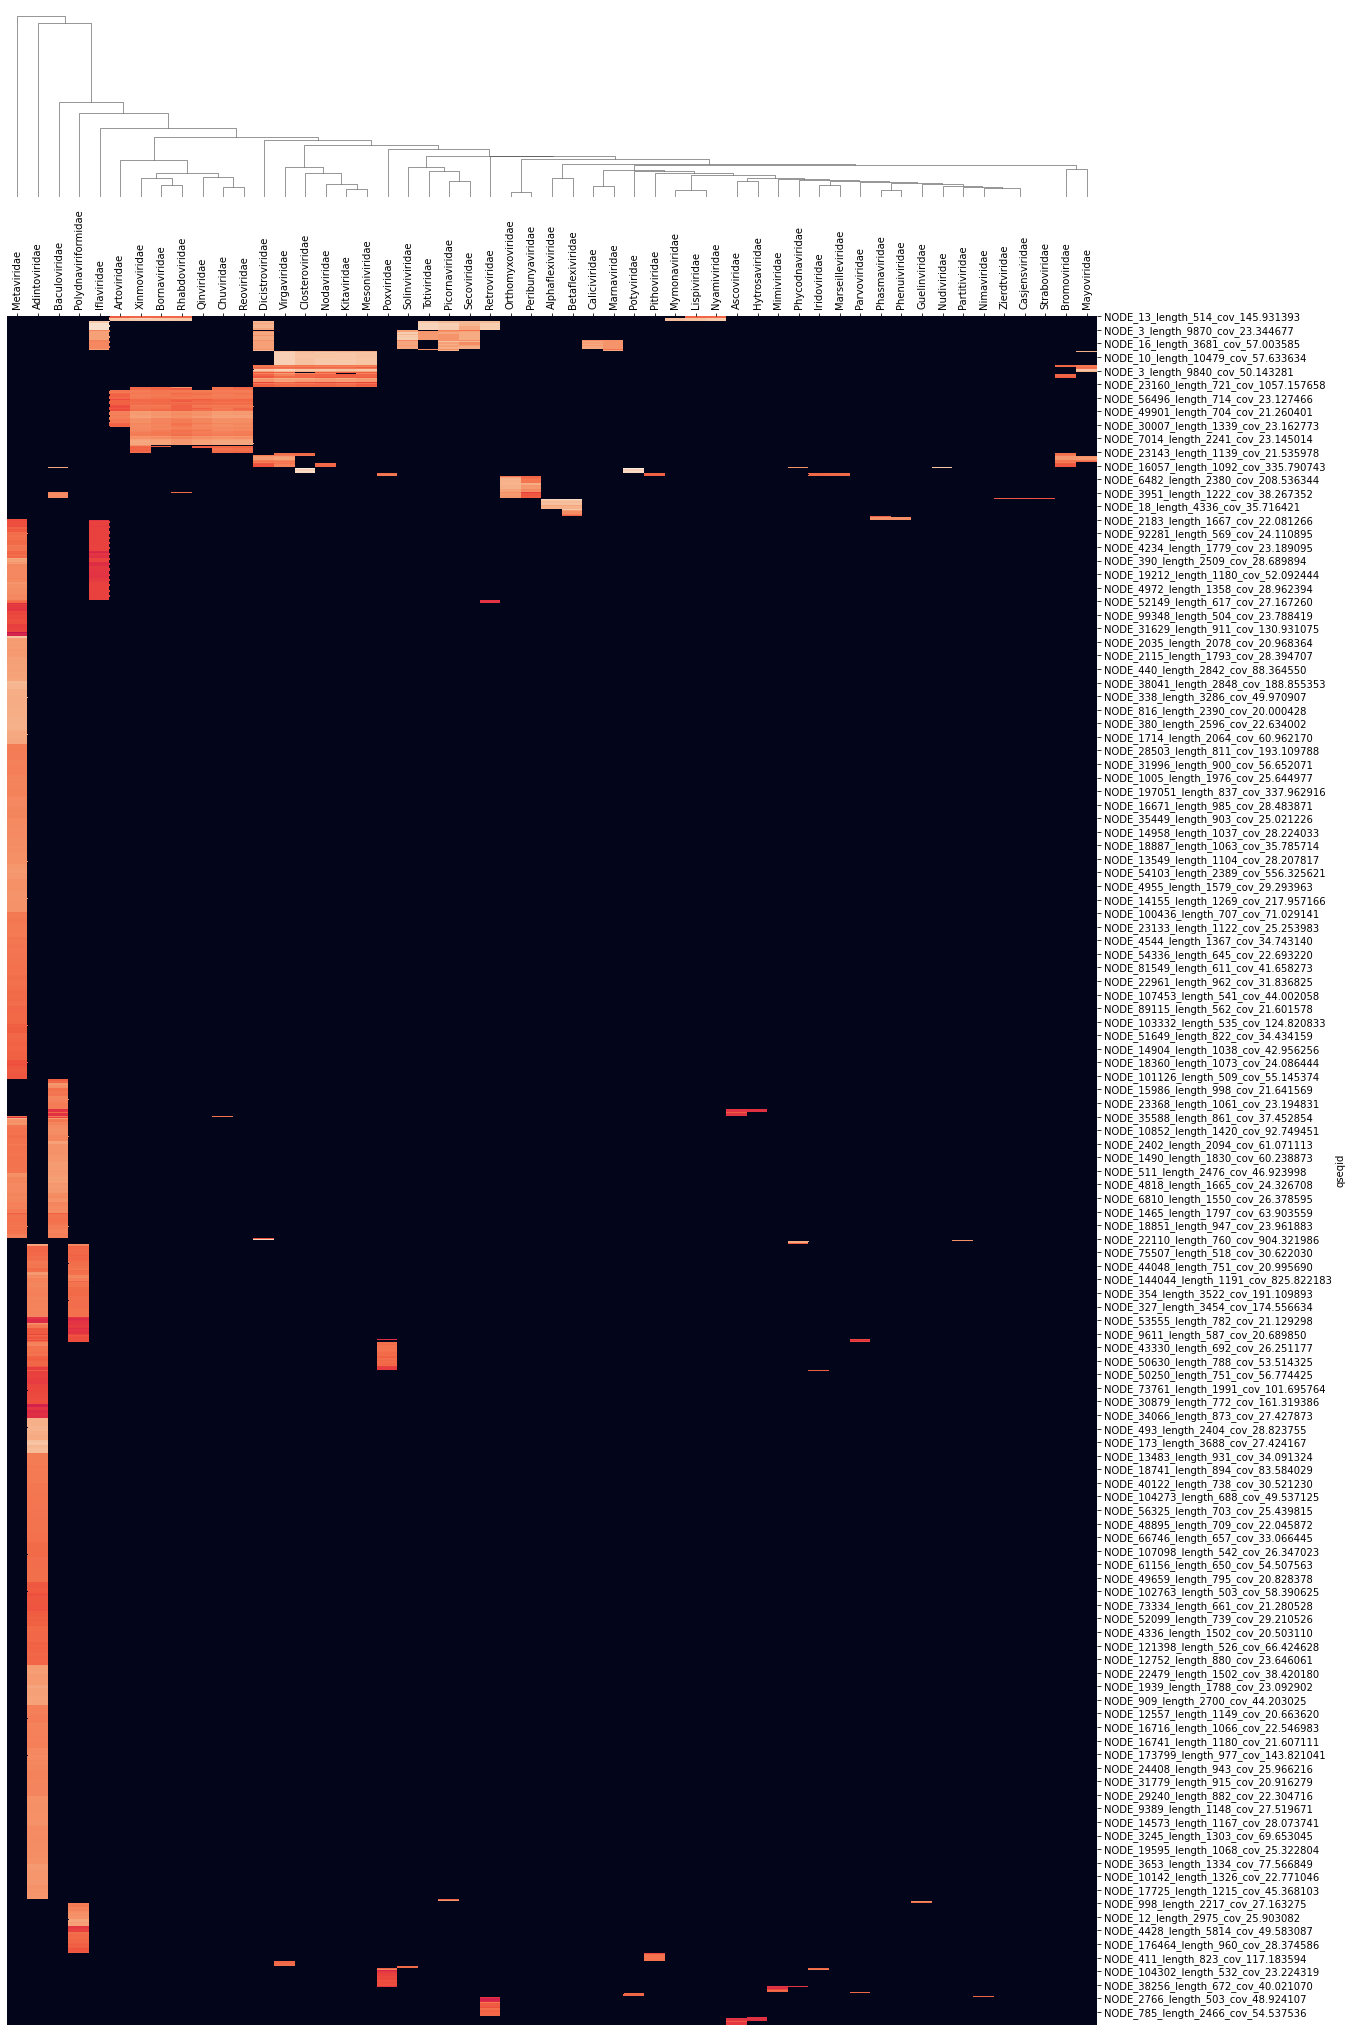

In [135]:
## the clustermap of alignment lengths by contigs and viral families
## it was customized to drop the denrogram for contigs
## and to adjust the heght of the dendrogram for viral families
## as it was suggested in:
## https://www.data-to-viz.com/graph/dendrogram.html

cg = sns.clustermap(np.log( cont_virfam_cover.fillna(0).astype(int).iloc[:, 1:] + 1 ).drop_duplicates() , figsize = [20, 30],
                    dendrogram_ratio=(.01, .1) );
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
#cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
cg.ax_cbar.set_visible(False);

cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.xaxis.tick_top() # x axis on top
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation = 90);

plt.gcf().subplots_adjust(hspace=0.125, wspace=0.125);

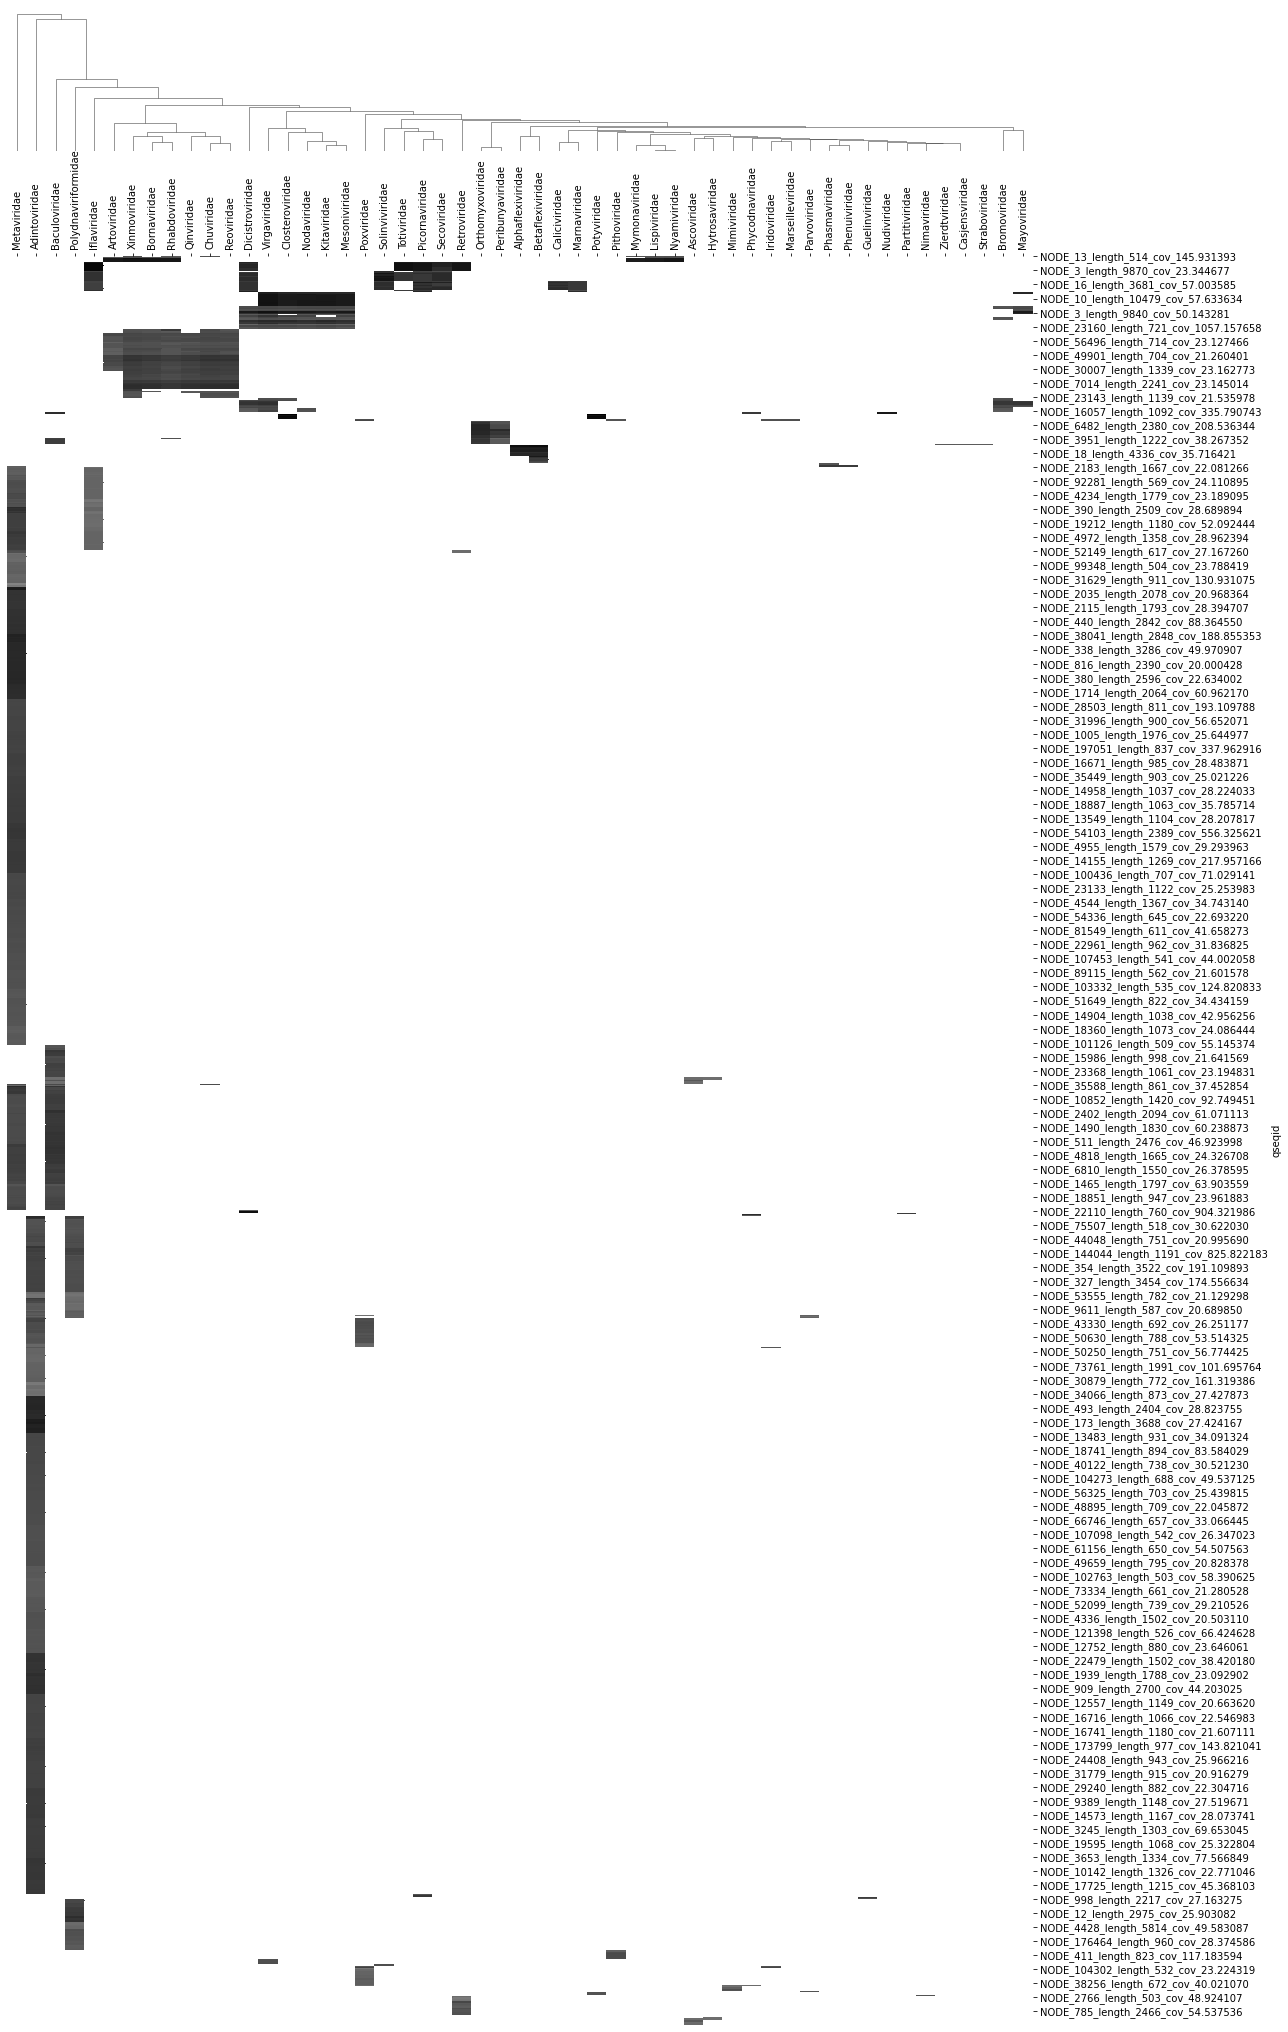

In [136]:
## the dendrogram ratio was made even less than in the cell above
#(cont_virfam_cover.fillna(0) > 0 ).iloc[:, 1:].drop_duplicates().index
cg = sns.clustermap(np.log( cont_virfam_cover.fillna(0).astype(int).iloc[:, 1:] + 1 ).drop_duplicates() ,
                    figsize = [20, 30],
                    cmap = 'gist_gray_r',
                    dendrogram_ratio= .075 );
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
#cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
cg.ax_cbar.set_visible(False);

cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.xaxis.tick_top() # x axis on top
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation = 90);

plt.gcf().subplots_adjust(hspace=0.11, wspace=0.11);

## https://www.data-to-viz.com/graph/dendrogram.html

In [138]:
gc.collect()

15

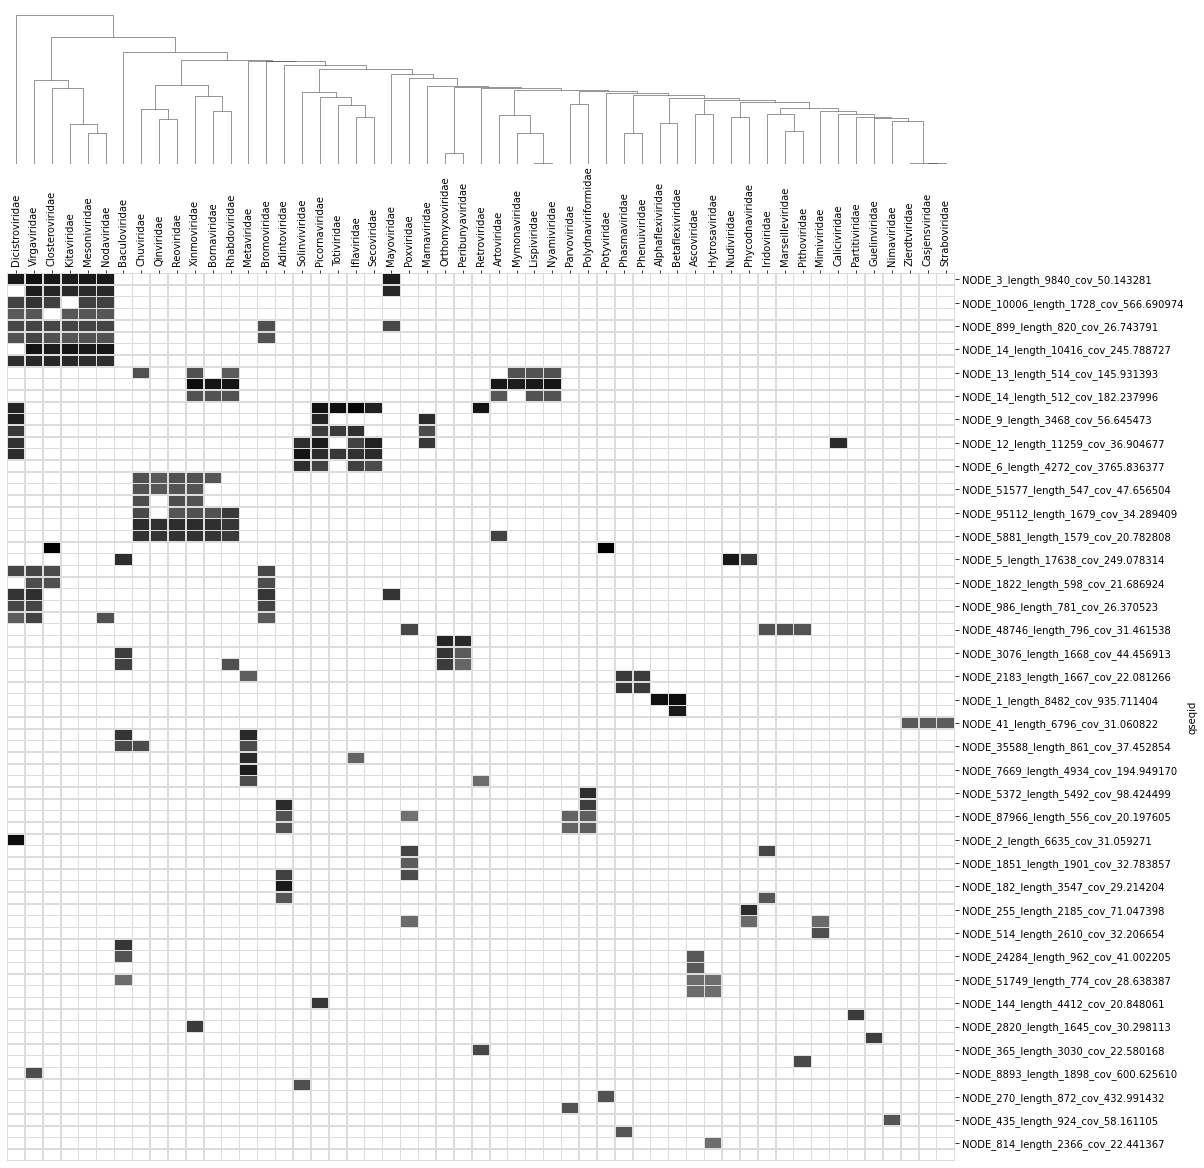

In [139]:
## the dendrogram ratio was made even less than in the cell above
tmpdf = cont_virfam_cover.iloc[:, 1:].copy()
tmpdf = tmpdf.iloc[ tmpdf.sum(axis = 1).values.argsort()[::-1] ]
sltd =  (tmpdf.fillna(0) > 0).drop_duplicates().index

cg = sns.clustermap(np.log( cont_virfam_cover.loc[sltd].fillna(0).astype(int).iloc[:, 1:] + 1 ).drop_duplicates() ,
                    figsize = [20, 18],
                    cmap = 'gist_gray_r',
                    linewidths = 0.5,
                    linecolor = 'gainsboro',
                    dendrogram_ratio= .15 );
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
#cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
cg.ax_cbar.set_visible(False);

cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.xaxis.tick_top() # x axis on top
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), rotation = 90);
plt.gcf().subplots_adjust(hspace=0.21, wspace=0.11);
plt.gcf().patch.set_facecolor('xkcd:white')

## https://www.data-to-viz.com/graph/dendrogram.html

In [141]:
gc.collect()

15

In [142]:
cont_1 = cont_foo[cont_foo.qseqid == 'NODE_18_length_9911_cov_192.833401']

In [143]:
cont_1.groupby('family').apply(get_cover)

family
                   7245
Dicistroviridae    2476
Iflaviridae        7104
Picornaviridae     4506
Retroviridae       4251
Secoviridae        2638
Totiviridae        5301
dtype: int64

In [145]:
cont_1.groupby('family').evalue.min()

family
                   0.000000e+00
Dicistroviridae    4.970000e-42
Iflaviridae        0.000000e+00
Picornaviridae     9.460000e-74
Retroviridae       2.320000e-59
Secoviridae        1.320000e-42
Totiviridae        3.830000e-56
Name: evalue, dtype: float64

In [146]:
cont_1.groupby('family').evalue.max()

family
                   0.000747
Dicistroviridae    0.000822
Iflaviridae        0.000784
Picornaviridae     0.000122
Retroviridae       0.000213
Secoviridae        0.000742
Totiviridae        0.000752
Name: evalue, dtype: float64

In [147]:
cont_1.loc[ cont_1['evalue'] == cont_1['evalue'].min() ]

,qseqid,caption_x,pident,length,mismatch,gapopen,qstart,qend,sstart,send,...,class,order,family,genus,species,data_type,project,prog,fxd_taxid,library_source
169939,NODE_18_length_9911_cov_192.833401,QKN88957.1,41.989,1679,894,28,4830,9728,1371,3015,...,Pisoniviricetes,Picornavirales,,,Picornavirales sp.,trx,PRJNA553565,blastx,1955153,Transcriptomic
171683,NODE_18_length_9911_cov_192.833401,QBP37019.1,33.861,1642,950,41,4980,9731,1506,3069,...,Pisoniviricetes,Picornavirales,Iflaviridae,,Lampyris noctiluca iflavirus 1,trx,PRJNA553565,blastx,2552988,Transcriptomic


In [148]:
cont_1.loc[ cont_1['length'] == cont_1['length'].max() ]

,qseqid,caption_x,pident,length,mismatch,gapopen,qstart,qend,sstart,send,...,class,order,family,genus,species,data_type,project,prog,fxd_taxid,library_source
169939,NODE_18_length_9911_cov_192.833401,QKN88957.1,41.989,1679,894,28,4830,9728,1371,3015,...,Pisoniviricetes,Picornavirales,,,Picornavirales sp.,trx,PRJNA553565,blastx,1955153,Transcriptomic


In [149]:
## count insect orders hits per contig
cont_iorder = flt_datacp_upd_fxd_eval03[flt_datacp_upd_fxd_eval03['class'] == 'Insecta']
cont_iorder = cont_iorder.groupby('qseqid')['order'].value_counts().unstack().fillna(0).astype(int)
cont_N_iorder = (cont_iorder > 0).sum()

In [150]:
#cont_superk
cont_superk.sort_values('Viruses', ascending = False).head(60)
#cont_insecta

kindom,Archaea,Bacteria,Eukaryota,Viruses
qseqid,,,,
NODE_11_length_9871_cov_141.816218,0,9,5,1181
NODE_18_length_9911_cov_192.833401,0,9,5,1181
NODE_167_length_9885_cov_400.052085,0,9,5,1181
NODE_2_length_9864_cov_21.485778,0,8,5,1178
NODE_2_length_9864_cov_21.112957,0,8,5,1178
NODE_2_length_9876_cov_21.231341,0,8,5,1178
NODE_2_length_9862_cov_22.302233,0,8,5,1178
NODE_2_length_9862_cov_21.854186,0,8,5,1178
NODE_4_length_9877_cov_22.894319,0,8,5,1178


### Read the blastn annotation data

In [151]:
ndata = pd.read_csv('BLASTn_genomic.raw.csv', sep='\t')

In [152]:
ndatat = pd.read_csv('BLAST_transcriptomic.raw.csv', sep='\t')

In [153]:
ndata['data_type'] = 'gen'
ndatat['data_type'] = 'trx'

In [154]:
ndatac = pd.concat([ndata, ndatat], axis = 0)

In [144]:
ndatac = ndatac.rename(columns={ "accession.version" : "caption_x"})

In [155]:
ndatac['prog'] = 'blastn'

In [156]:
ndatac.head()

,Unnamed: 0,accession.version,tax_id,superkingdom,phylum,family,species,qseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,data_type,prog
0,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_4064_length_1942_cov_206.579756,97.419,155.0,4.0,0.0,949.0,1103.0,1.0,155.0,1.190000e-65,265.0,gen,blastn
1,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_1309_length_1847_cov_278.989955,97.419,155.0,4.0,0.0,967.0,1121.0,1.0,155.0,1.130000e-65,265.0,gen,blastn
2,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_971_length_1933_cov_313.968584,97.419,155.0,4.0,0.0,943.0,1097.0,1.0,155.0,1.190000e-65,265.0,gen,blastn
3,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_4371_length_1305_cov_199.216000,97.419,155.0,4.0,0.0,945.0,1099.0,1.0,155.0,7.940000e-66,265.0,gen,blastn
4,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_4958_length_1304_cov_260.345076,97.419,155.0,4.0,0.0,944.0,1098.0,1.0,155.0,7.930000e-66,265.0,gen,blastn


In [157]:
ndatac[ndatac.evalue < 10**-3][['qseqid','superkingdom','family']].drop_duplicates().superkingdom.value_counts()

Eukaryota    632756
Bacteria      11723
Viruses        3157
Archaea         771
Name: superkingdom, dtype: int64

In [158]:
ndatac[(ndatac.evalue < 10**-3) & (
    ndatac.superkingdom == 'Viruses') ][['qseqid','family']].drop_duplicates().family.value_counts()

Herpesviridae       554
Myoviridae          545
Podoviridae         325
Siphoviridae        320
Retroviridae        314
Paramyxoviridae     289
Solemoviridae       279
Betaflexiviridae     68
Potyviridae          25
Closteroviridae      24
Polydnaviridae       19
Mimiviridae          14
Hytrosaviridae       12
Microviridae          9
Ascoviridae           8
Flaviviridae          7
Orthomyxoviridae      4
Ackermannviridae      3
Dicistroviridae       2
Demerecviridae        2
Adintoviridae         1
Nimaviridae           1
Caliciviridae         1
Herelleviridae        1
Phycodnaviridae       1
Poxviridae            1
Iridoviridae          1
Name: family, dtype: int64

In [159]:
ndatac[(ndatac.evalue < 0.001) & (ndatac.superkingdom == 'Viruses') ]['qseqid'].drop_duplicates().to_csv(
    'contigs_mapped_to_viral_with_blastn_against_nt_eval03.csv')

In [160]:
ndatac.head() #qseqid.nunique()

,Unnamed: 0,accession.version,tax_id,superkingdom,phylum,family,species,qseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,data_type,prog
0,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_4064_length_1942_cov_206.579756,97.419,155.0,4.0,0.0,949.0,1103.0,1.0,155.0,1.190000e-65,265.0,gen,blastn
1,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_1309_length_1847_cov_278.989955,97.419,155.0,4.0,0.0,967.0,1121.0,1.0,155.0,1.130000e-65,265.0,gen,blastn
2,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_971_length_1933_cov_313.968584,97.419,155.0,4.0,0.0,943.0,1097.0,1.0,155.0,1.190000e-65,265.0,gen,blastn
3,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_4371_length_1305_cov_199.216000,97.419,155.0,4.0,0.0,945.0,1099.0,1.0,155.0,7.940000e-66,265.0,gen,blastn
4,0,XR_003033788.1,9913,Eukaryota,Chordata,Bovidae,Bos taurus,NODE_4958_length_1304_cov_260.345076,97.419,155.0,4.0,0.0,944.0,1098.0,1.0,155.0,7.930000e-66,265.0,gen,blastn


In [161]:
ndatac.family.value_counts()

Enterobacteriaceae    910623
Nymphalidae           825401
Yersiniaceae          634693
Noctuidae             581217
Chrysomelidae         465752
                       ...  
Neothyridae                1
Penthalodidae              1
Siphonariidae              1
Geoglossaceae              1
Podabrocephalidae          1
Name: family, Length: 3067, dtype: int64

In [162]:
ndatac[ndatac.family == 'Nymphalidae']

,Unnamed: 0,accession.version,tax_id,superkingdom,phylum,family,species,qseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,data_type,prog
871400,24016,HQ378508.1,76239,Eukaryota,Arthropoda,Nymphalidae,Libythea celtis,NODE_96_length_13311_cov_212.437839,74.874,10738.0,2129.0,434.0,2855.0,13243.0,1265.0,11782.0,0.000000e+00,4357.0,gen,blastn
871401,24016,HQ378508.1,76239,Eukaryota,Arthropoda,Nymphalidae,Libythea celtis,NODE_47_length_11846_cov_506.010601,74.761,9608.0,1914.0,390.0,9.0,9293.0,10684.0,1265.0,0.000000e+00,3836.0,gen,blastn
871402,24016,HQ378508.1,76239,Eukaryota,Arthropoda,Nymphalidae,Libythea celtis,NODE_25_length_11798_cov_351.826961,74.702,9574.0,1910.0,391.0,1.0,9250.0,10650.0,1265.0,0.000000e+00,3790.0,gen,blastn
871403,24016,HQ378508.1,76239,Eukaryota,Arthropoda,Nymphalidae,Libythea celtis,NODE_104_length_11923_cov_1091.086957,74.778,9666.0,1927.0,390.0,43.0,9385.0,10742.0,1265.0,0.000000e+00,3871.0,gen,blastn
871404,24016,HQ378508.1,76239,Eukaryota,Arthropoda,Nymphalidae,Libythea celtis,NODE_35_length_11935_cov_839.548653,74.778,9666.0,1927.0,390.0,2556.0,11898.0,1265.0,10742.0,0.000000e+00,3871.0,gen,blastn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212779,171024,MW318942.1,2798450,Eukaryota,Arthropoda,Nymphalidae,Smerina manoro,NODE_799_length_6374_cov_875.037506,88.172,93.0,11.0,0.0,5.0,97.0,311.0,219.0,1.520000e-19,113.0,trx,blastn
4212780,171025,MW317907.1,2798337,Eukaryota,Arthropoda,Nymphalidae,Cyrestis adaemon,NODE_19489_length_880_cov_1065.824242,85.149,303.0,45.0,0.0,1.0,303.0,303.0,1.0,6.690000e-80,311.0,trx,blastn
4212781,171026,MW317991.1,2798462,Eukaryota,Arthropoda,Nymphalidae,Ypthima granulosa,NODE_21258_length_796_cov_2442.139001,77.612,804.0,160.0,16.0,1.0,794.0,353.0,1146.0,9.390000e-128,470.0,trx,blastn
4212782,171027,MW317946.1,2799044,Eukaryota,Arthropoda,Nymphalidae,Miriamica sp. KSP_4486,NODE_21258_length_796_cov_2442.139001,78.200,789.0,152.0,13.0,1.0,779.0,353.0,1131.0,9.320000e-133,486.0,trx,blastn


In [163]:
gc.collect()

330

In [167]:
ndatac.columns

Index(['Unnamed: 0', 'accession.version', 'tax_id', 'superkingdom', 'phylum',
       'family', 'species', 'qseqid', 'pident', 'length', 'mismatch',
       'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore',
       'data_type', 'prog'],
      dtype='object')

In [164]:
ndatac_viral_blastn = ndatac[(ndatac.evalue < 10**-3) & (ndatac.superkingdom == 'Viruses') ].drop_duplicates()

In [168]:
## with e-value < 0.05 -- (54666, 966, 2219, 32)
ndatac_viral_blastn.shape[0], ndatac_viral_blastn.qseqid.nunique(), ndatac_viral_blastn['accession.version'].nunique() , ndatac_viral_blastn.family.nunique() 

(52791, 786, 2175, 27)

In [ ]:
# 52791 - 54666 хитов
# 786   - 966   контигов
# 2175  - 2219  уникальных идентификаторов гомологичных вирусных последовательностей
# 27    - 32    вирусных семейства

In [169]:
## there are no empty or incorrect values for tax_id
ndatac.tax_id.isna().sum()

0

In [170]:
## there are no empty values for species
ndatac[['superkingdom', 'phylum', 'family',
       'species']].isna().sum()

superkingdom    63320
phylum          74671
family          84512
species             0
dtype: int64

In [181]:
## superkingdom is empty for artificial sequences
ndatac[ndatac.superkingdom.isna()].sort_values('length', ascending = False)

,Unnamed: 0,accession.version,tax_id,superkingdom,phylum,family,species,qseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,data_type,prog
8340,522,MK433574.1,32630,NaN,NaN,NaN,synthetic construct,NODE_1_length_8518_cov_573.079995,95.458,8498.0,378.0,7.0,1.0,8494.0,8498.0,5.0,0.000,13548.0,trx,blastn
8409,523,MK433575.1,32630,NaN,NaN,NaN,synthetic construct,NODE_1_length_8518_cov_573.079995,95.434,8498.0,380.0,7.0,1.0,8494.0,8498.0,5.0,0.000,13537.0,trx,blastn
8202,520,MK433572.1,32630,NaN,NaN,NaN,synthetic construct,NODE_1_length_8518_cov_573.079995,95.458,8498.0,378.0,7.0,1.0,8494.0,8498.0,5.0,0.000,13548.0,trx,blastn
7995,517,MK433569.1,32630,NaN,NaN,NaN,synthetic construct,NODE_1_length_8518_cov_573.079995,95.399,8498.0,383.0,7.0,1.0,8494.0,8498.0,5.0,0.000,13520.0,trx,blastn
7926,516,MK433568.1,32630,NaN,NaN,NaN,synthetic construct,NODE_1_length_8518_cov_573.079995,95.411,8498.0,382.0,7.0,1.0,8494.0,8498.0,5.0,0.000,13525.0,trx,blastn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973849,181104,MG188291.1,2081740,NaN,NaN,NaN,Cloning vector pCA-DEST1402,NODE_1922_length_521_cov_190.154506,100.000,28.0,0.0,0.0,1.0,28.0,8259.0,8286.0,0.026,52.8,trx,blastn
2991087,181129,MG188316.1,2081765,NaN,NaN,NaN,Cloning vector pCA-DEST2430,NODE_1922_length_521_cov_190.154506,100.000,28.0,0.0,0.0,1.0,28.0,8302.0,8329.0,0.026,52.8,trx,blastn
2960414,181085,MG188272.1,2081721,NaN,NaN,NaN,Cloning vector pCA-DEST1110,NODE_682_length_780_cov_75.675862,100.000,28.0,0.0,0.0,753.0,780.0,7245.0,7218.0,0.039,52.8,trx,blastn
2973853,181104,MG188291.1,2081740,NaN,NaN,NaN,Cloning vector pCA-DEST1402,NODE_1935_length_519_cov_976.140086,100.000,28.0,0.0,0.0,492.0,519.0,8601.0,8628.0,0.026,52.8,trx,blastn


# Filtering the BLASTx annotation results by e-value and selecting virus-positive contigs

In [182]:
datacp_upd_fxd_eval03.shape, flt_datacp_upd_fxd_eval03.shape
# ((5178786, 29), (5175489, 29))

((5178786, 29), (5175489, 29))

In [183]:
datacp.shape, datacp_upd.shape
# ((6182908, 27), (6200054, 28))

((6182908, 27), (6200054, 28))

In [184]:
data_evalue_normal = flt_datacp_upd_fxd_eval03 ## datacp_upd[datacp_upd.evalue < 0.05]

In [185]:
data_evalue_normal.library_source.value_counts()

Genomic           3706484
Transcriptomic    1469005
Name: library_source, dtype: int64

In [187]:
gc.collect()

15

In [194]:
print ( f'''the number of total BLASTx hits - {data_evalue_normal.shape[0]}
the number of unique contigs - {data_evalue_normal.qseqid.nunique()}
the number of unique proteins matched - {data_evalue_normal.Caption.nunique()}
the number of matched families - {data_evalue_normal.family.nunique()} ''')

the number of total BLASTx hits - 5175489
the number of unique contigs - 13314
the number of unique proteins matched - 496872
the number of matched families - 1825 


* the number of virus-positive contigs

In [189]:
data_evalue_normal[data_evalue_normal.kindom == 'Viruses'].qseqid.unique().size

3137

In [190]:
vir_data_evalue_normal = data_evalue_normal[data_evalue_normal.kindom == 'Viruses']

In [192]:
print ( f'''the number of total BLASTx hits - {vir_data_evalue_normal.shape[0]}
the number of unique contigs - {vir_data_evalue_normal.qseqid.nunique()}
the number of unique viral proteins matched - {vir_data_evalue_normal.Caption.nunique()}
the number of matched viral families - {vir_data_evalue_normal.family.nunique()} ''')
# (186148, 3137, 9918, 54)

the number of total BLASTx hits - 186148
the number of unique contigs - 3137
the number of unique viral proteins matched - 9918
the number of matched viral families - 54 


In [195]:
data_evalue_normal.columns

Index(['qseqid', 'caption_x', 'pident', 'length', 'mismatch', 'gapopen',
       'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'Caption',
       'genid', 'title', 'taxid', 'caption_y', 'kindom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'data_type', 'project', 'prog',
       'fxd_taxid', 'library_source'],
      dtype='object')

In [196]:
data_evalue_normal[['qseqid', 'Caption', 'kindom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'data_type', 'project']].nunique()

qseqid        13314
Caption      496872
kindom            5
phylum          173
class           239
order           667
family         1825
genus          4377
species       11907
data_type         3
project          17
dtype: int64

In [197]:
## select virus-positive contigs
viruses = data_evalue_normal[data_evalue_normal.kindom == 'Viruses'] 

In [198]:
viruses.shape

(186148, 29)

In [199]:
## data_evalue_normal -- all viral and non-viral
## each contig is annotated according to the best bitscore and e-value
## select the rows annotated with both superkingdom and family ranks
data_evalue_normal_ = data_evalue_normal[~ ( data_evalue_normal.kindom.eq('') | data_evalue_normal.family.eq('') ) ]
## select viral hits
viral_data_evalue_normal_    = data_evalue_normal_[data_evalue_normal_.kindom.eq('Viruses')]
## select non-viral hits
nonviral_data_evalue_normal_ = data_evalue_normal_[~data_evalue_normal_.kindom.eq('Viruses')]

## leave only the hits with minimal e-values for each contig
viral_idx = viral_data_evalue_normal_.groupby(['qseqid'])['evalue'].transform(min) == viral_data_evalue_normal_['evalue']
sel_viral_data_evalue = viral_data_evalue_normal_[ viral_idx ]
## get the alignments of maximal length for each contig
viral_idx = sel_viral_data_evalue.groupby(['qseqid'])['bitscore'].transform(max) == sel_viral_data_evalue['bitscore']
sel_viral_data_evalue = sel_viral_data_evalue[ viral_idx ]
sel_viral_data_evalue = sel_viral_data_evalue.groupby('qseqid').first().reset_index()

nonviral_idx = nonviral_data_evalue_normal_.groupby(['qseqid'])[
    'evalue'].transform(min) == nonviral_data_evalue_normal_['evalue']
sel_nonviral_data_evalue = nonviral_data_evalue_normal_[ nonviral_idx ]
nonviral_idx = sel_nonviral_data_evalue.groupby(['qseqid'])['bitscore'].transform(max) == sel_nonviral_data_evalue['bitscore']
sel_nonviral_data_evalue = sel_nonviral_data_evalue[ nonviral_idx ]
sel_nonviral_data_evalue = sel_nonviral_data_evalue.groupby('qseqid').first().reset_index()

In [1040]:
#sel_viral_data_evalue [sel_viral_data_evalue.qseqid == 'NODE_2_length_1254_cov_3679.576577']

In [1037]:
#sel_viral_data_evalue = sel_viral_data_evalue[['qseqid', 'caption_x', 'pident', 'length', 'mismatch', 'gapopen',
#       'qstart', 'qend', 'evalue', 'bitscore', 'Caption',
#       'genid', 'title', 'taxid', 'caption_y', 'kindom', 'phylum', 'class',
#       'order', 'family', 'genus', 'species', 'data_type', 'project', 'prog',
#       'fxd_taxid']].drop_duplicates()

In [173]:
#data_evalue_normal_.bitscore.max(), data_evalue_normal_.length.max()
#sel_viral_data_evalue2.shape

In [201]:
sns.set_context("paper")

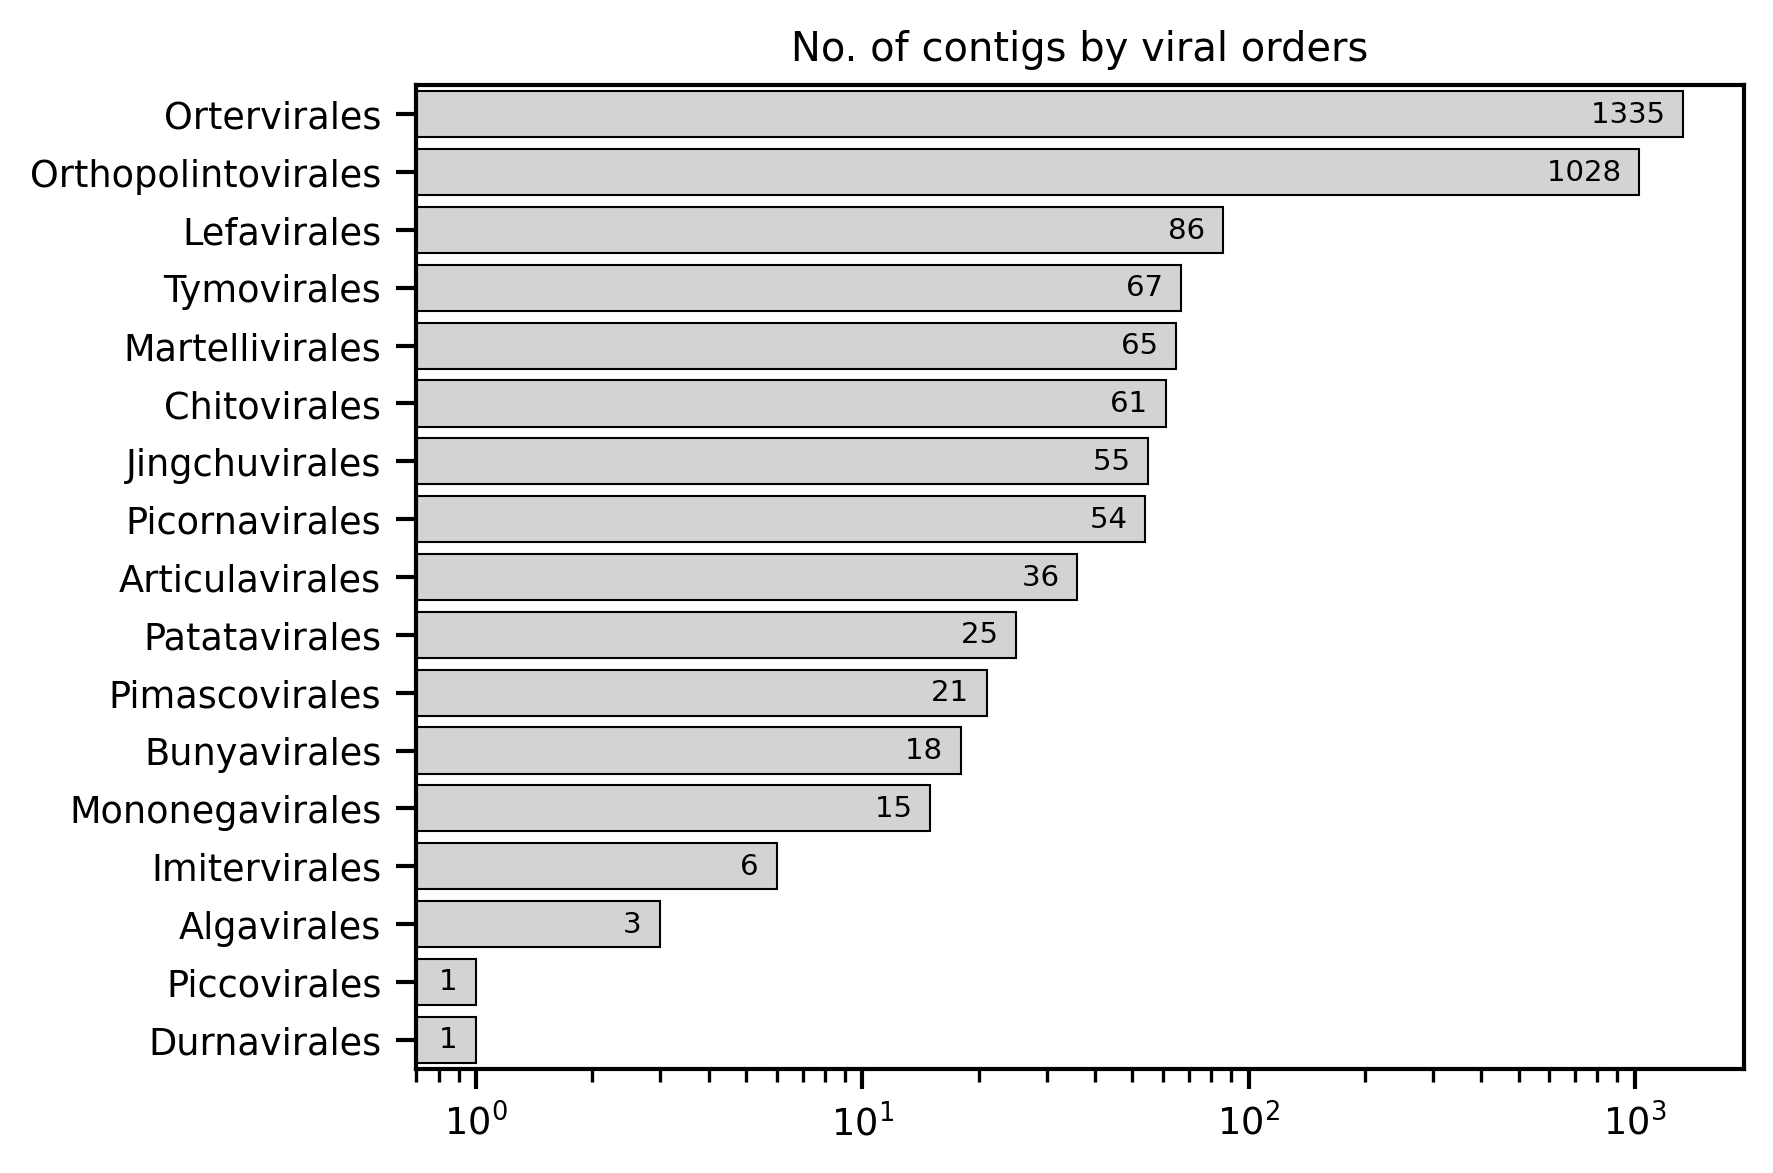

In [202]:
_, axs = plt.subplots(figsize = [6, 4], dpi = 300)

data2plot = sel_viral_data_evalue.order.value_counts()
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]
#ax = plt.barh(  )

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
#plt.gcf().
axs.set_xscale('log')
axs.set_title('No. of contigs by viral orders')
axs.set_xlabel('')
axs.set_yticklabels( data2plot.index,
                     rotation = 0 );
#axs.grid(alpha = .5, linewidth=0.2 )
#axs.bar_label( );

for i, p in enumerate(axs.patches):
    width = p.get_width() 
    axs.text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)
    
plt.tight_layout();

In [203]:
sel_viral_data_evalue.shape, sel_nonviral_data_evalue.shape

((2954, 29), (13252, 29))

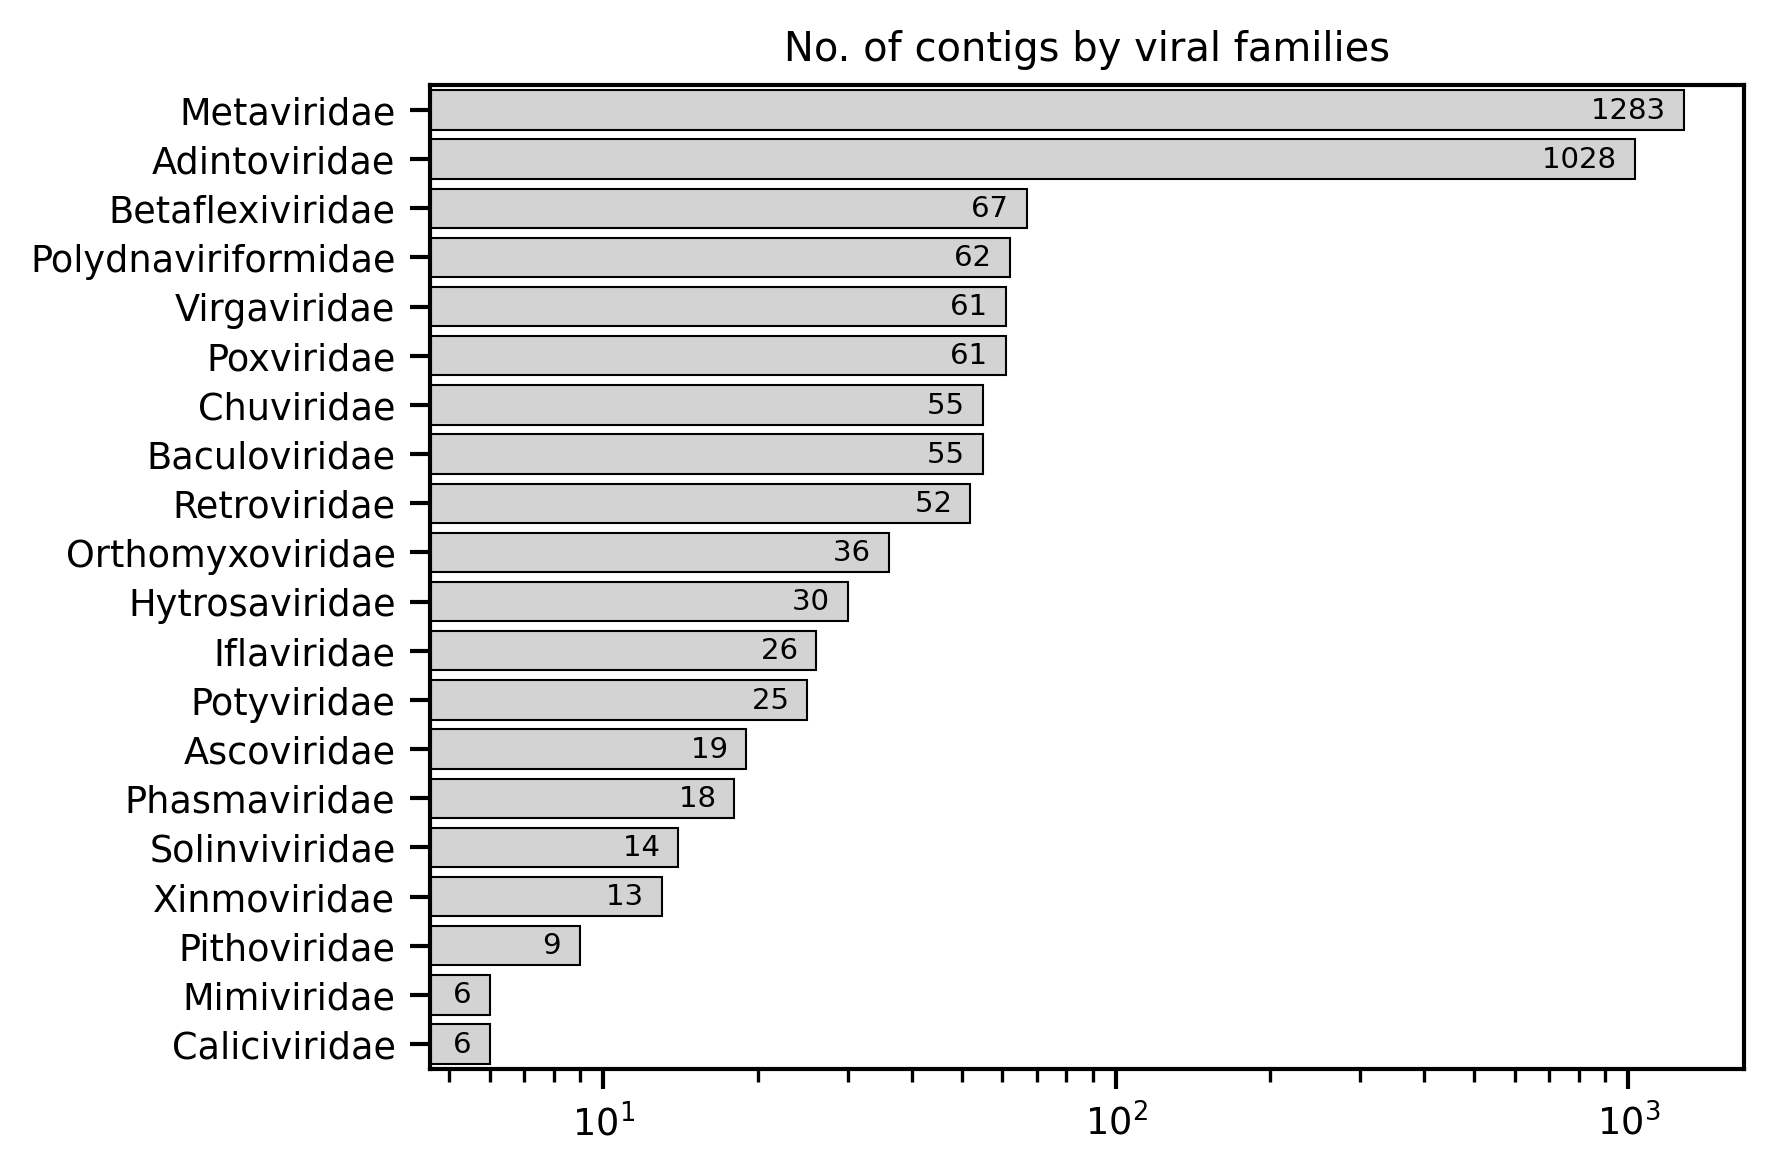

In [204]:
_, axs = plt.subplots(figsize = [6, 4], dpi = 300)

data2plot = sel_viral_data_evalue.family.value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs.set_xscale('log')
axs.set_title('No. of contigs by viral families')
axs.set_xlabel('')
axs.set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs.patches):
    width = p.get_width() 
    axs.text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)
    
plt.tight_layout();

In [206]:
gc.collect()

15

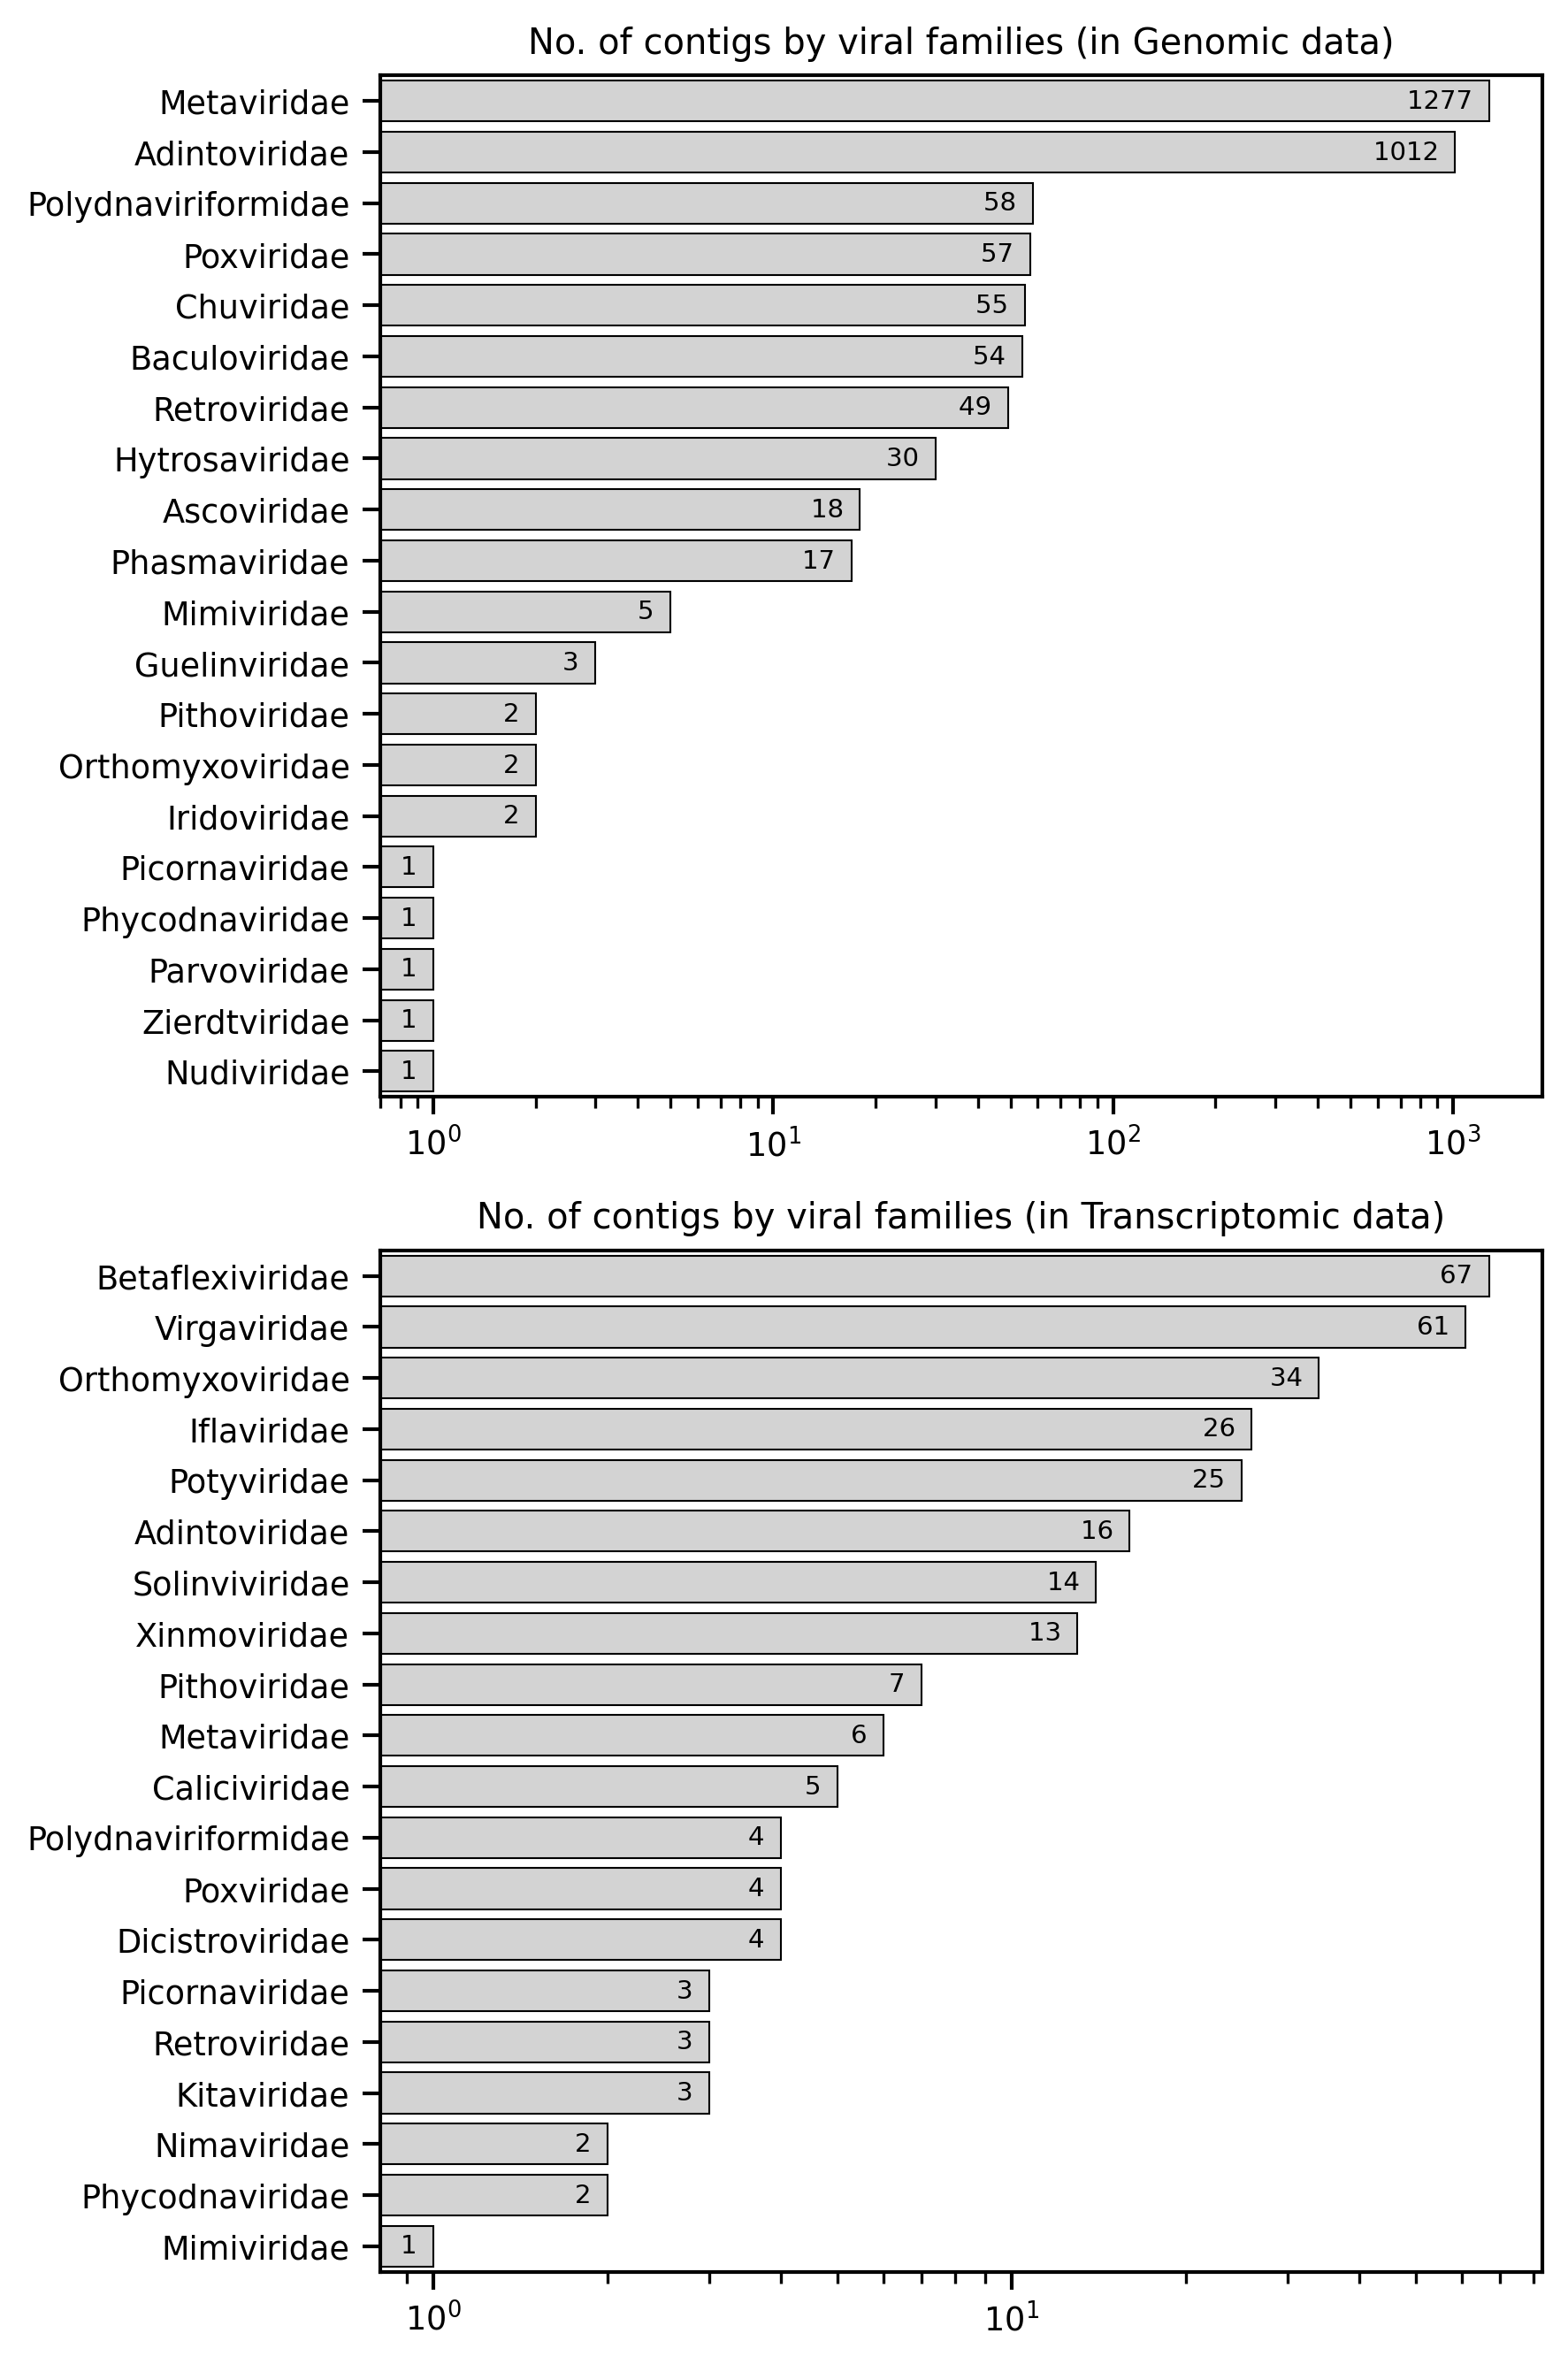

In [207]:
#_, axs = plt.subplots(nrows = 2, figsize = [6, 9], dpi = 300)
#
#for i in range( len(sel_viral_data_evalue.library_source.unique()) ): 
#    dt = sel_viral_data_evalue.library_source.unique()[i]
#    data2plot = sel_viral_data_evalue[sel_viral_data_evalue.library_source == dt].family.value_counts().head(20)
#    data2plot = pd.DataFrame( data2plot[~(data2plot.index == '')] )#.reset_index() 
#    #sns.barplot( y=data2plot.index, x=data2plot.family, ax = axs[i])
#    #axs[i].set_title(dt)
#    #axs[i].set_xscale('log')
#    
#    
#    sns.barplot( x = data2plot.family,
#                 y = data2plot.index, 
#                 ax = axs[i] ,
#                 edgecolor = 'black', linewidth = 0.5,
#                 color = 'lightgray' )    
#    axs[i].set_xscale('log')
#    axs[i].set_title(f'No. of contigs by viral families (in {dt} data)')
#    axs[i].set_xlabel('')
#    axs[i].set_yticklabels( data2plot.index,
#                           rotation = 0 );
#    for i, p in enumerate(axs[i].patches):
#        width = p.get_width() 
#        axs[i].text(width , p.get_y()+p.get_height()/2., 
#                    'wwww', #f'{data2plot.family.values[i]} ',
#                    ha="right", va='center', size = 7 )
#plt.tight_layout();

_, axs = plt.subplots(nrows = 2, figsize = [6, 9], dpi = 300)

data2plot = sel_viral_data_evalue[sel_viral_data_evalue.library_source == 'Genomic'].family.value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[0] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[0].set_xscale('log')
axs[0].set_title('No. of contigs by viral families (in Genomic data)')
axs[0].set_xlabel('')
axs[0].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[0].patches):
    width = p.get_width() 
    axs[0].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)
    
data2plot = sel_viral_data_evalue[sel_viral_data_evalue.library_source == 'Transcriptomic'].family.value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[1] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[1].set_xscale('log')
axs[1].set_title('No. of contigs by viral families (in Transcriptomic data)')
axs[1].set_xlabel('')
axs[1].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[1].patches):
    width = p.get_width() 
    axs[1].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)

plt.tight_layout();

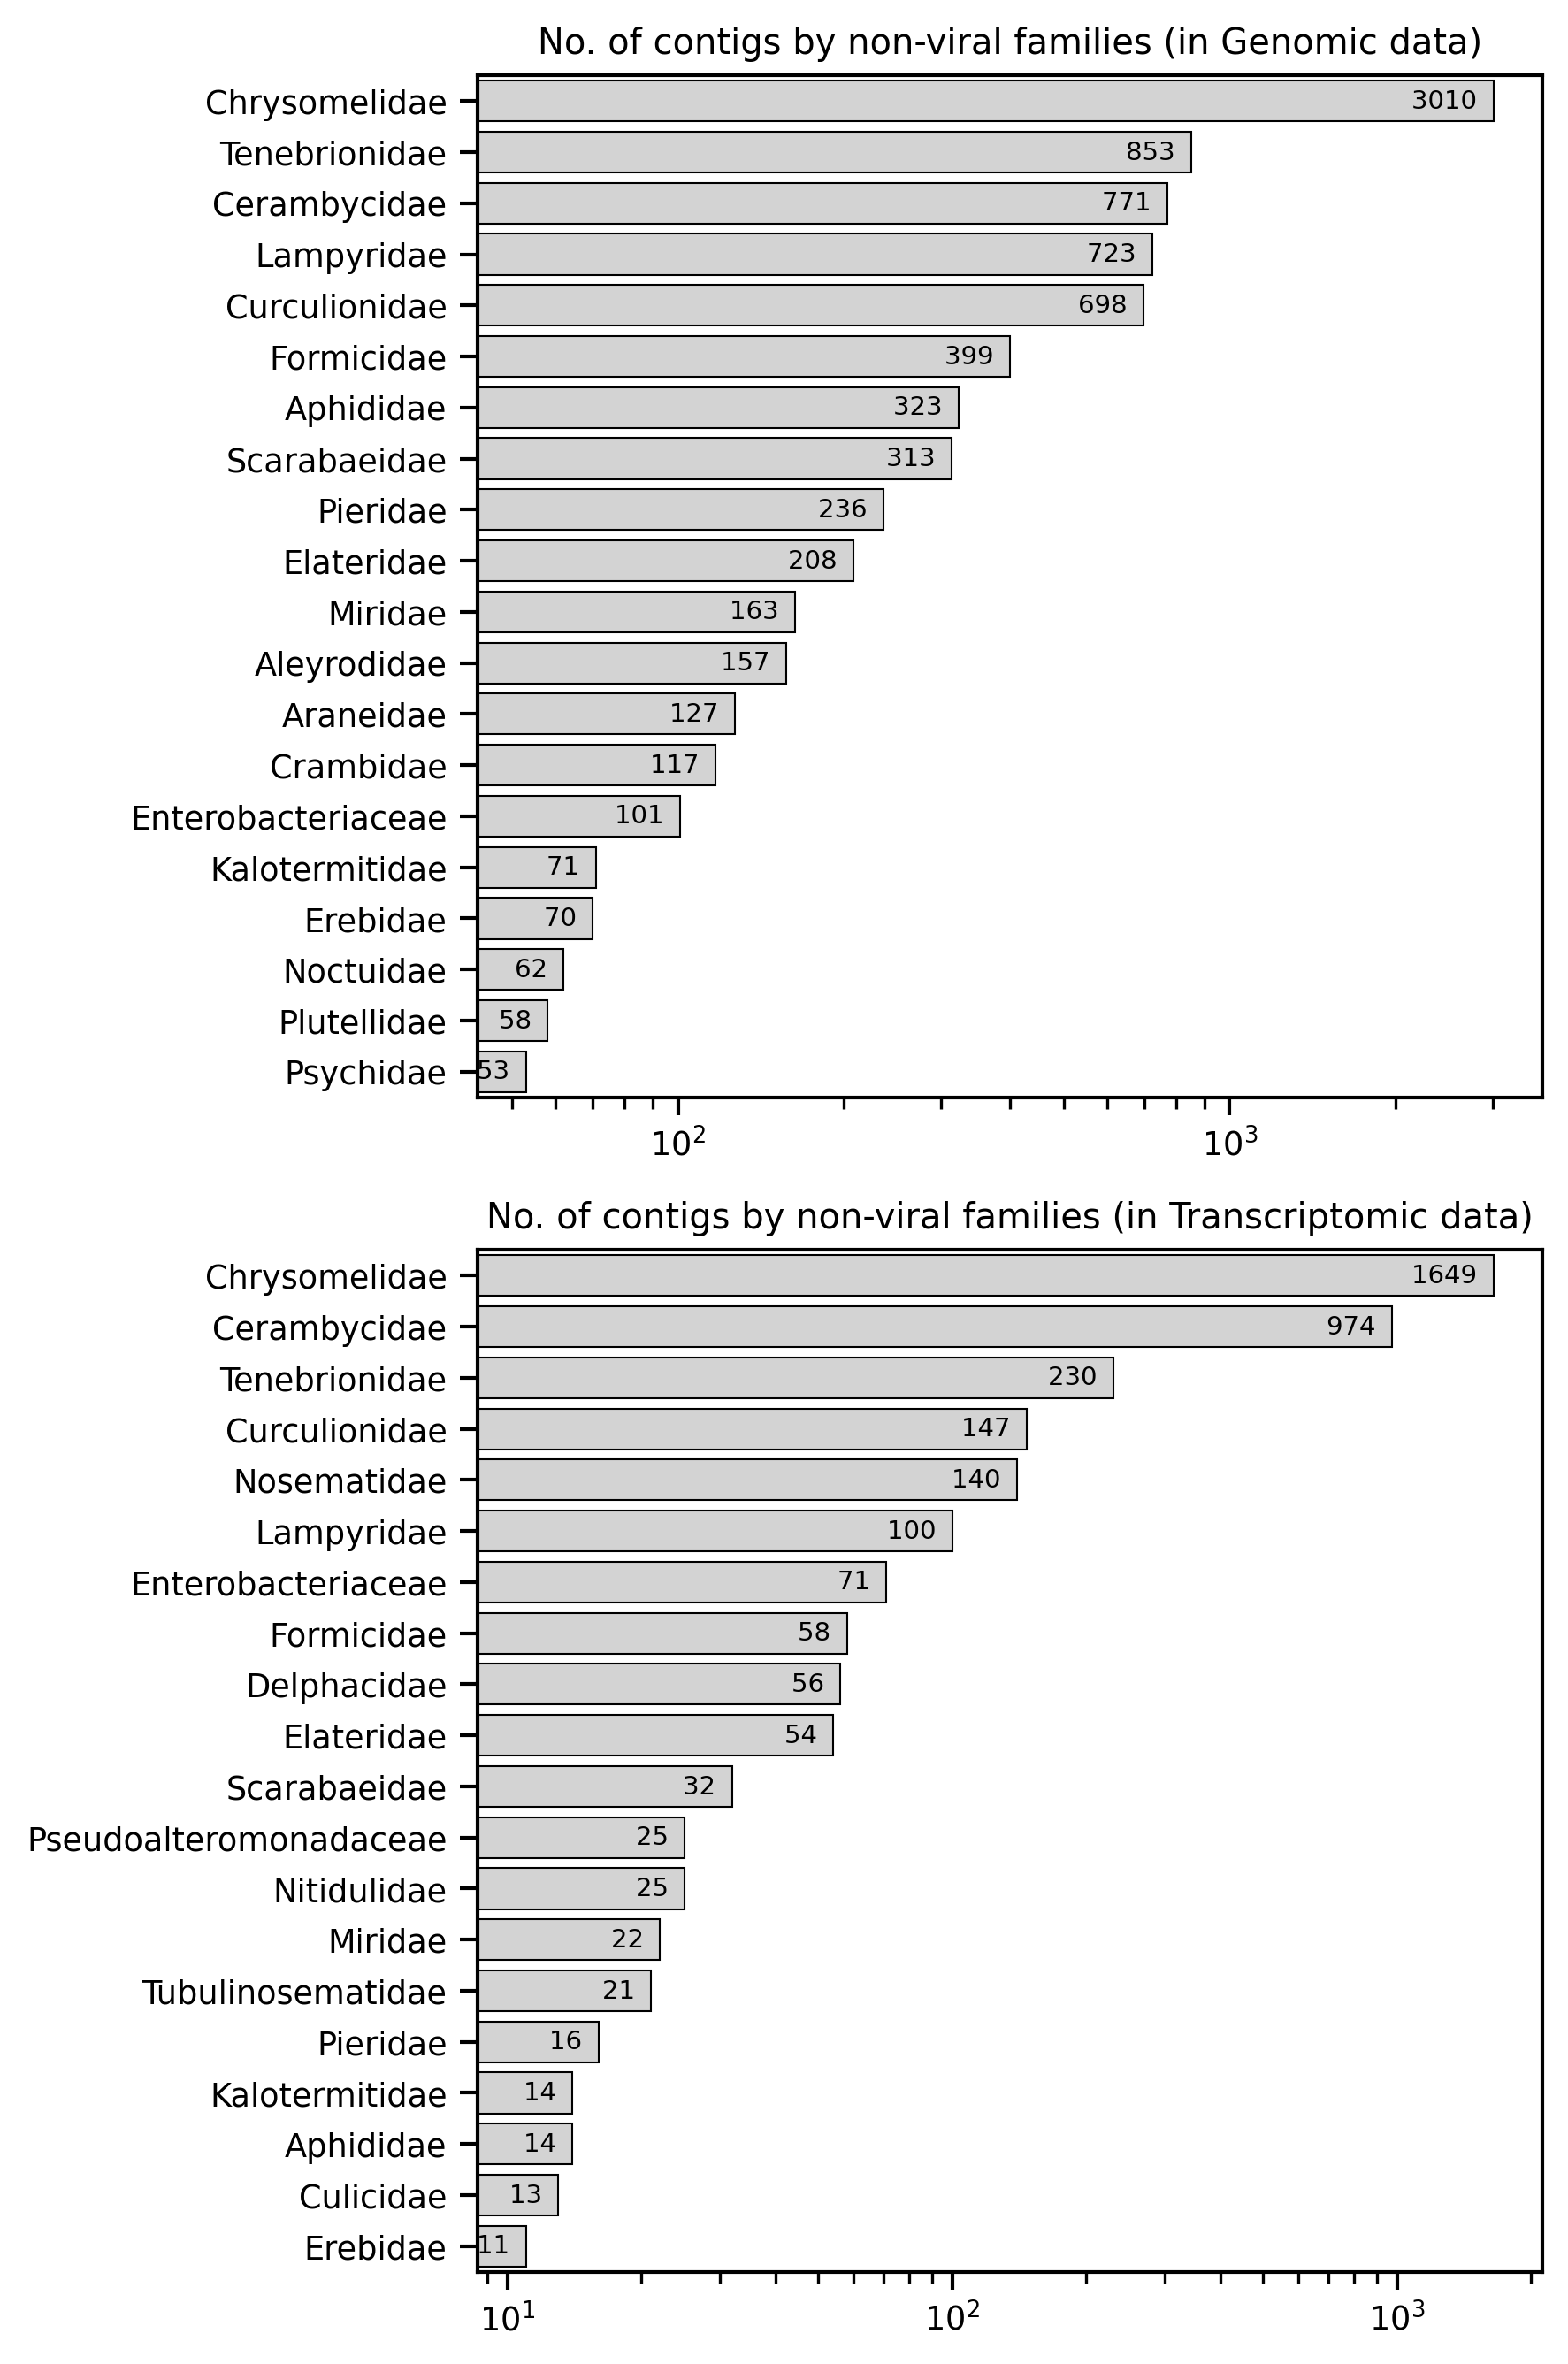

In [208]:
_, axs = plt.subplots(nrows = 2, figsize = [6, 9], dpi = 300)

data2plot = sel_nonviral_data_evalue[sel_nonviral_data_evalue.library_source == 'Genomic'].family.value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[0] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[0].set_xscale('log')
axs[0].set_title('No. of contigs by non-viral families (in Genomic data)')
axs[0].set_xlabel('')
axs[0].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[0].patches):
    width = p.get_width() 
    axs[0].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)
    
data2plot = sel_nonviral_data_evalue[sel_nonviral_data_evalue.library_source == 'Transcriptomic'].family.value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[1] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[1].set_xscale('log')
axs[1].set_title('No. of contigs by non-viral families (in Transcriptomic data)')
axs[1].set_xlabel('')
axs[1].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[1].patches):
    width = p.get_width() 
    axs[1].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)

plt.tight_layout();

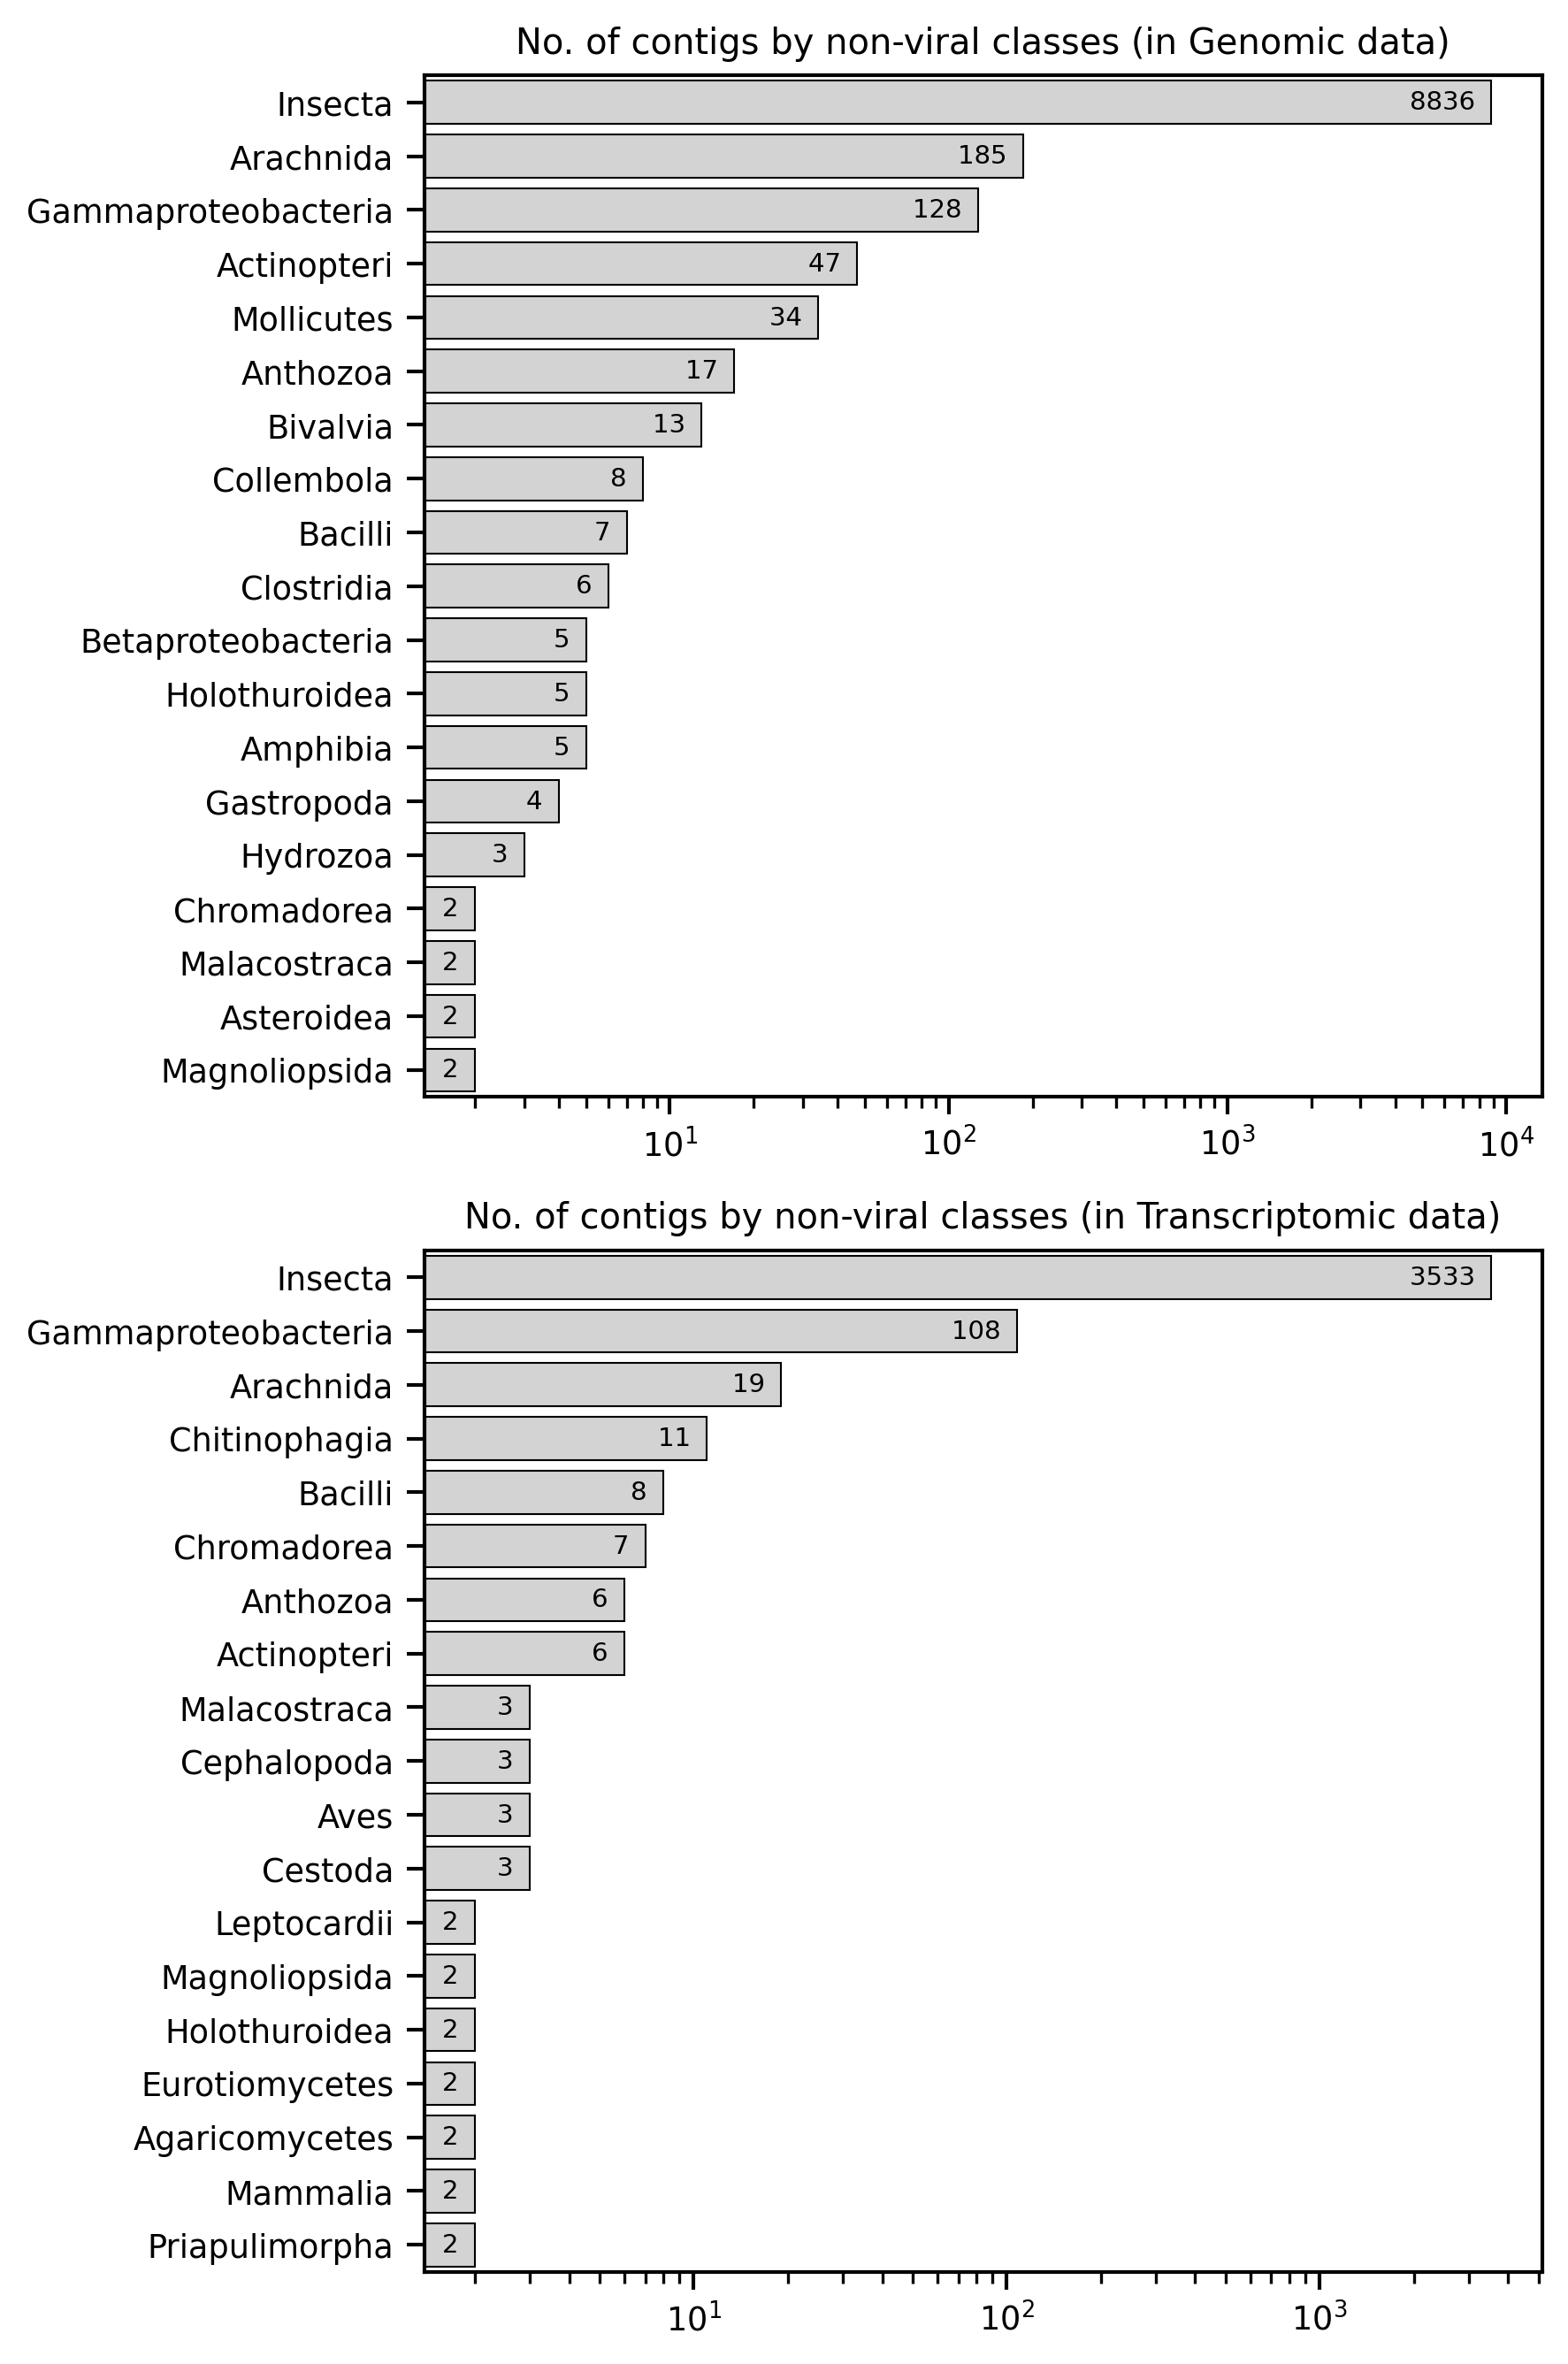

In [209]:
_, axs = plt.subplots(nrows = 2, figsize = [6, 9], dpi = 300)

data2plot = sel_nonviral_data_evalue[sel_nonviral_data_evalue.library_source == 'Genomic']['class'].value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[0] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[0].set_xscale('log')
axs[0].set_title('No. of contigs by non-viral classes (in Genomic data)')
axs[0].set_xlabel('')
axs[0].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[0].patches):
    width = p.get_width() 
    axs[0].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)
    
data2plot = sel_nonviral_data_evalue[sel_nonviral_data_evalue.library_source == 'Transcriptomic']['class'].value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[1] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[1].set_xscale('log')
axs[1].set_title('No. of contigs by non-viral classes (in Transcriptomic data)')
axs[1].set_xlabel('')
axs[1].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[1].patches):
    width = p.get_width() 
    axs[1].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)

plt.tight_layout();

In [210]:
sel_viral_data_evalue.groupby('library_source').family.value_counts()

library_source  family             
Genomic         Metaviridae            1277
                Adintoviridae          1012
                Polydnaviriformidae      58
                Poxviridae               57
                Chuviridae               55
                Baculoviridae            54
                Retroviridae             49
                Hytrosaviridae           30
                Ascoviridae              18
                Phasmaviridae            17
                Mimiviridae               5
                Guelinviridae             3
                Iridoviridae              2
                Orthomyxoviridae          2
                Pithoviridae              2
                Caliciviridae             1
                Nudiviridae               1
                Parvoviridae              1
                Phycodnaviridae           1
                Picornaviridae            1
                Rhabdoviridae             1
                Zierdtviridae           

In [211]:
sel_nonviral_data_evalue.groupby('kindom').family.value_counts().head(60)

kindom     family                
Bacteria   Enterobacteriaceae         172
           Pseudoalteromonadaceae      25
           Spiroplasmataceae           22
           Moraxellaceae               12
           Chitinophagaceae            11
           Entomoplasmataceae          11
           Chromatiaceae               10
           Yersiniaceae                 9
           Burkholderiaceae             5
           Staphylococcaceae            5
           Clostridiaceae               4
           Pseudomonadaceae             4
           Bacillaceae                  3
           Pasteurellaceae              3
           Aquificaceae                 2
           Enterococcaceae              2
           Listeriaceae                 2
           Streptococcaceae             2
           Alcaligenaceae               1
           Carnobacteriaceae            1
           Colwelliaceae                1
           Mycoplasmataceae             1
           Oscillospiraceae             1


In [279]:
#sel_viral_data_evalue.groupby('library_source').family.value_counts()

In [212]:
sel_nonviral_data_evalue.family.value_counts()

Chrysomelidae      4659
Cerambycidae       1745
Tenebrionidae      1083
Curculionidae       845
Lampyridae          823
                   ... 
Phytoseiidae          1
Asteriidae            1
Myxobolidae           1
Erysiphaceae          1
Acanthasteridae       1
Name: family, Length: 163, dtype: int64

In [213]:
## data_evalue_normal -- all viral and non-viral
## each contig is annotated according to the best bitscore and e-value
data_evalue_normal_2 = data_evalue_normal[~ ( data_evalue_normal.kindom.eq('') ) & ( data_evalue_normal.family.eq('') ) ]
#data_evalue_normal_['evalue'] = data_evalue_normal_['evalue'] + 10**-100
viral_data_evalue_normal_2    = data_evalue_normal_2[data_evalue_normal_2.kindom.eq('Viruses')]

viral_idx = viral_data_evalue_normal_2.groupby(['qseqid'])['evalue'].transform(min) == viral_data_evalue_normal_2['evalue']
sel_viral_data_evalue2 = viral_data_evalue_normal_2[ viral_idx ]
viral_idx = sel_viral_data_evalue2.groupby(['qseqid'])['bitscore'].transform(max) == sel_viral_data_evalue2['bitscore']
sel_viral_data_evalue2 = sel_viral_data_evalue2[ viral_idx ]
sel_viral_data_evalue2 = sel_viral_data_evalue2.groupby('qseqid').first().reset_index()


In [214]:
sel_viral_data_evalue2.shape

(1662, 29)

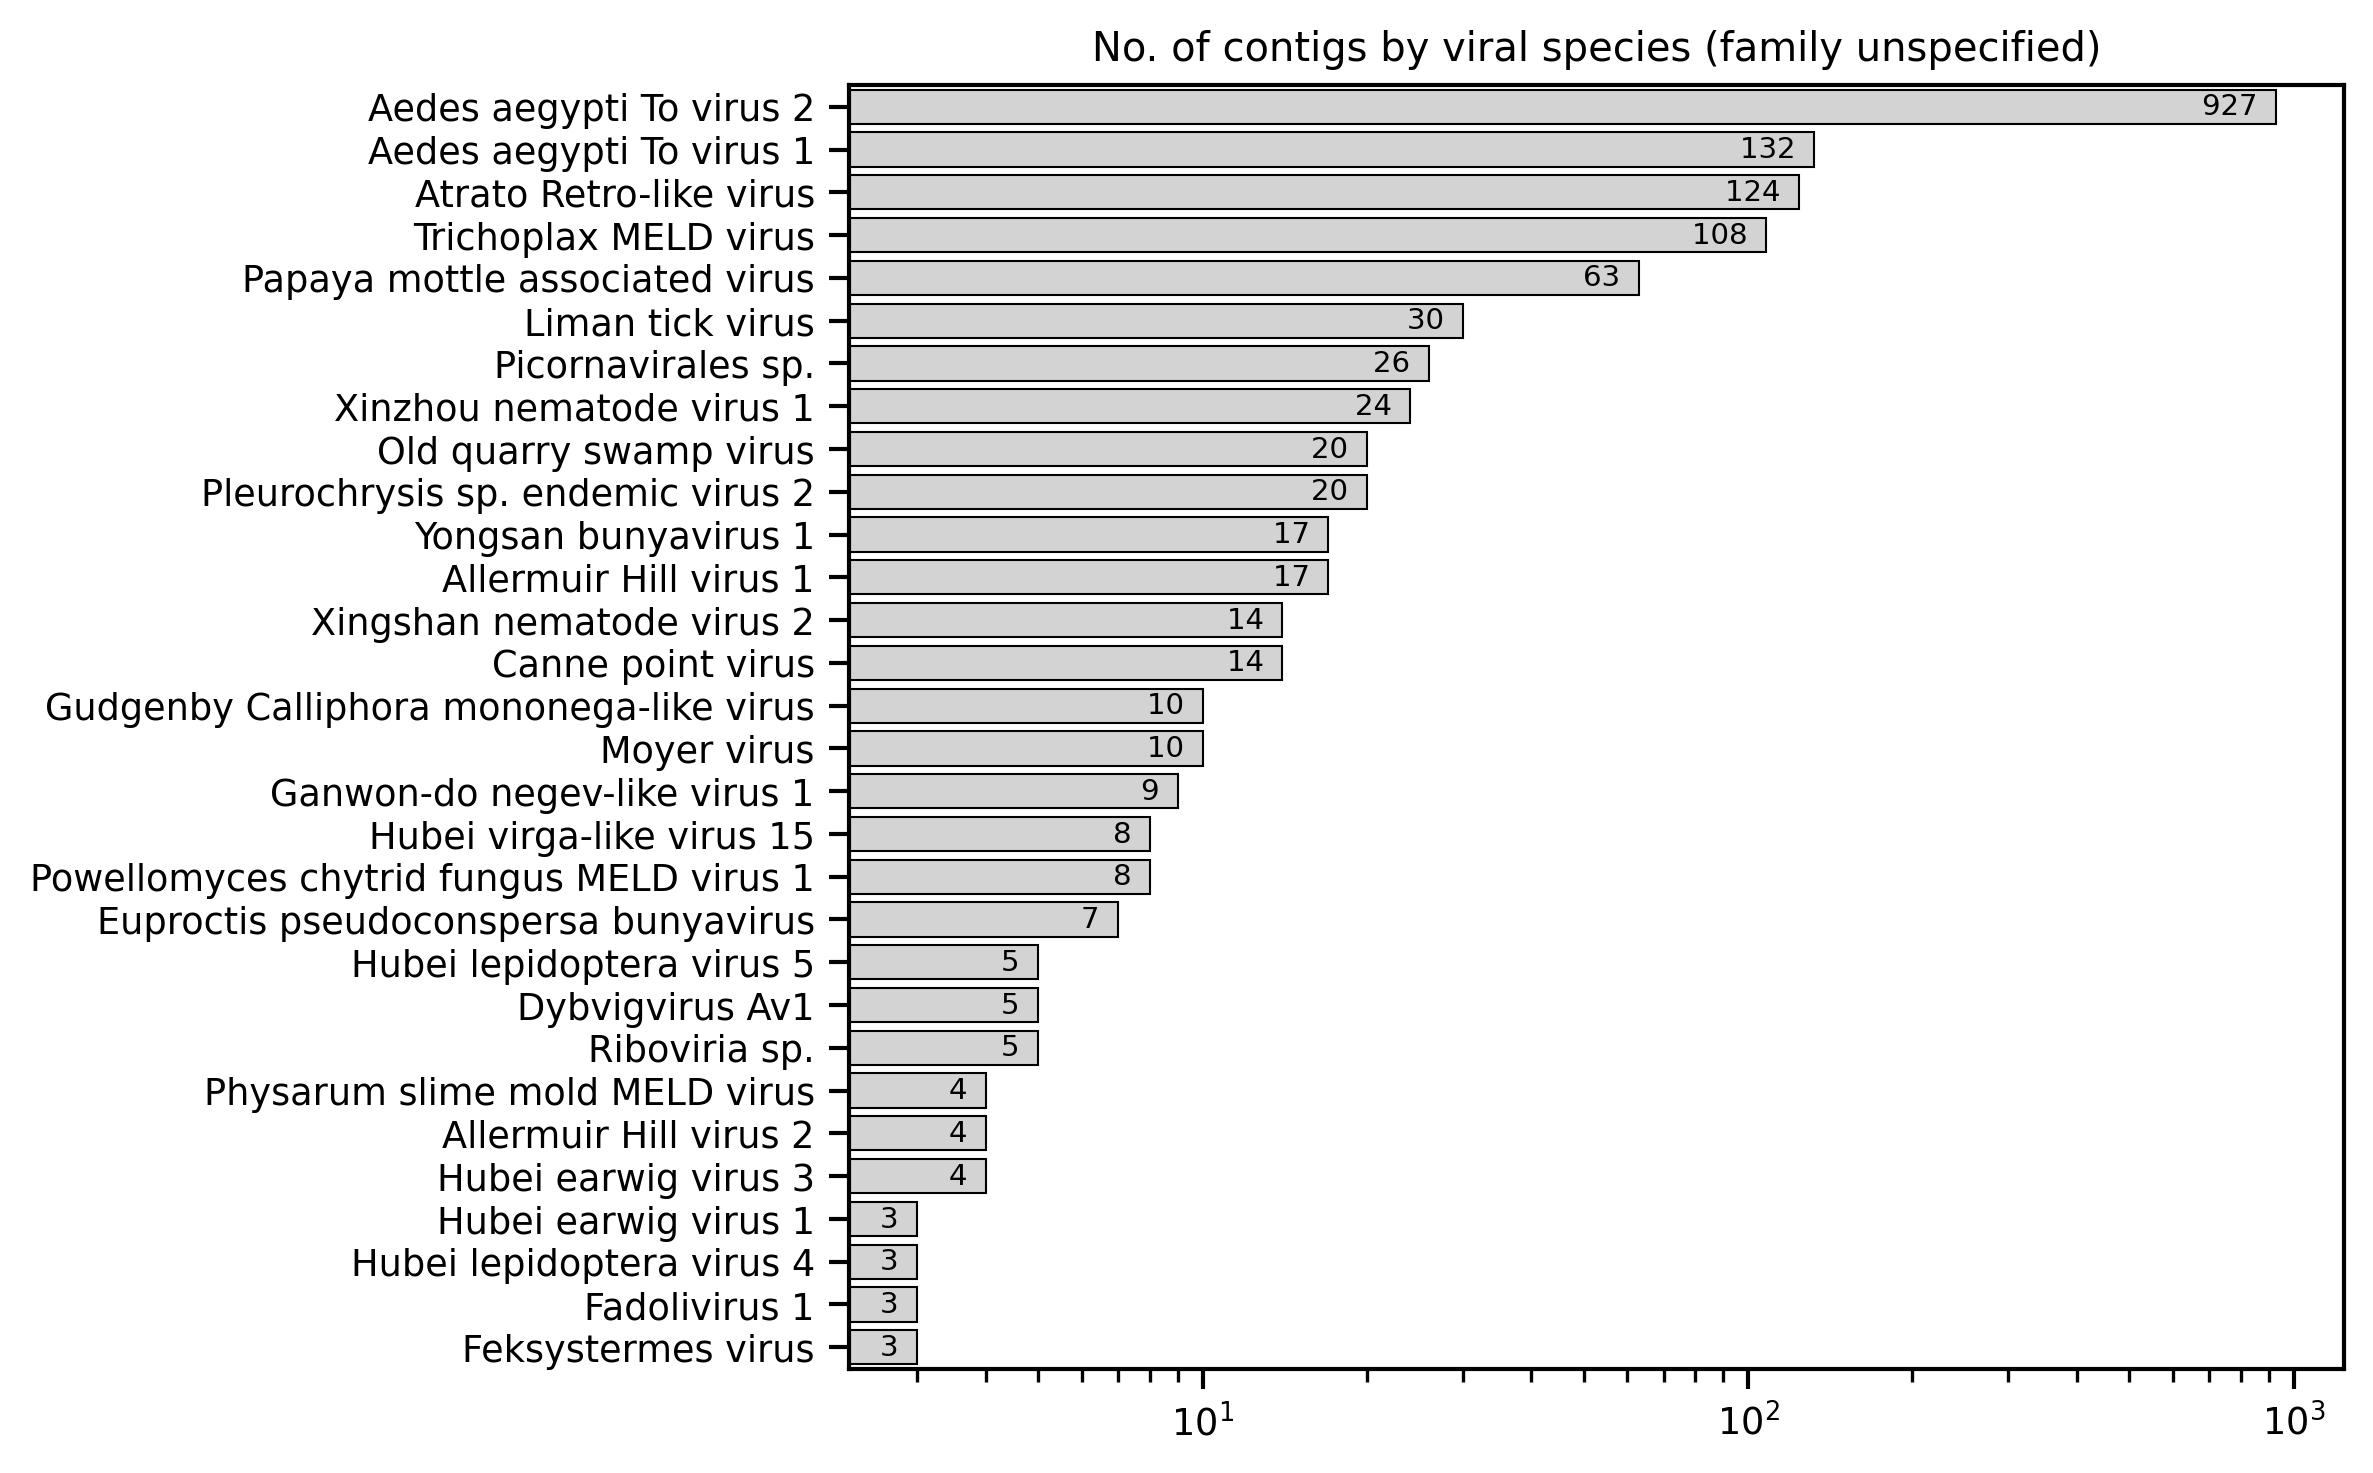

In [215]:
#sel_viral_data_evalue2.species.value_counts()
#_ = plt.figure(figsize=[ 8, 8])
#data2plot = sel_viral_data_evalue2.species.value_counts().head(30)
#data2plot = data2plot[~(data2plot.index == '')].iloc[::-1]
#ax = plt.barh( width = data2plot,
#               y = data2plot.index )
#plt.gcf().axes[0].set_xscale('log')
#plt.gcf().axes[0].set_yticklabels( data2plot.index,
#                                   rotation = 0 );
#
_, axs = plt.subplots(figsize = [8, 5], dpi = 300)

data2plot = sel_viral_data_evalue2.species.value_counts().head(30)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs.set_xscale('log')
axs.set_title('No. of contigs by viral species (family unspecified)')
axs.set_xlabel('')
axs.set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs.patches):
    width = p.get_width() 
    axs.text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)
    
plt.tight_layout();

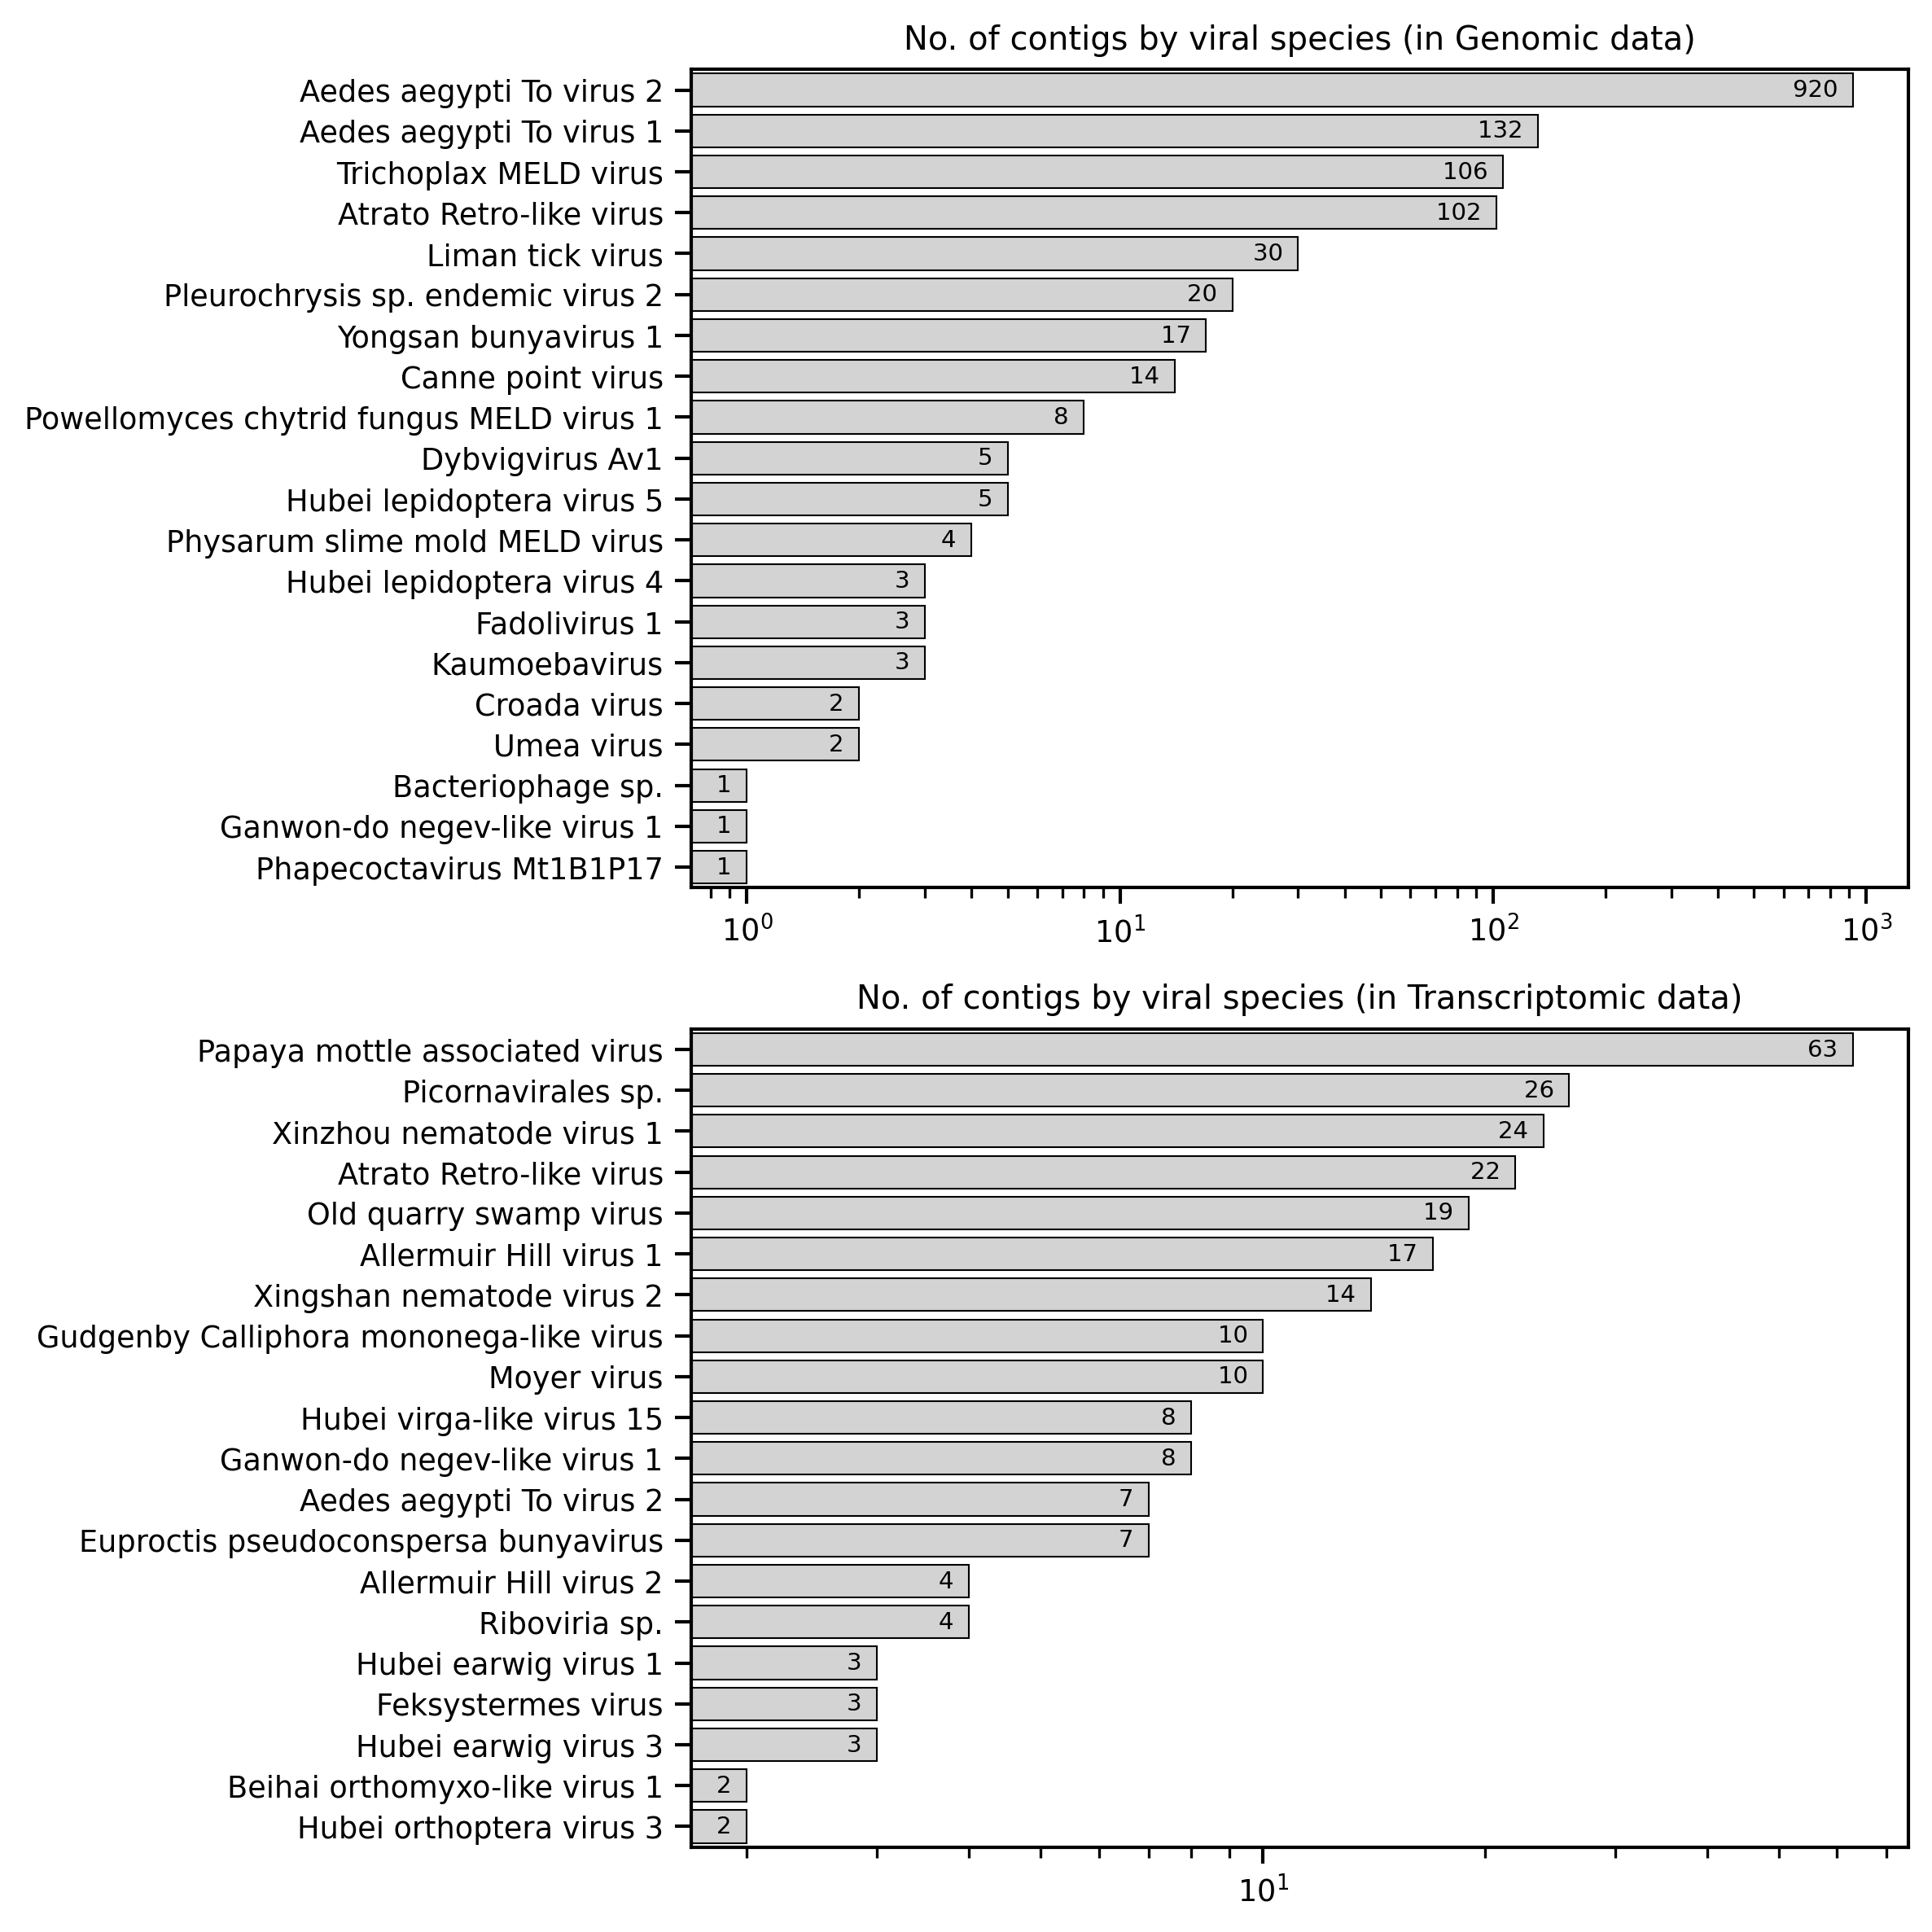

In [216]:
_, axs = plt.subplots(nrows = 2, figsize = [8, 8], dpi = 300)

data2plot = sel_viral_data_evalue2[sel_viral_data_evalue2.library_source == 'Genomic'].species.value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[0] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[0].set_xscale('log')
axs[0].set_title('No. of contigs by viral species (in Genomic data)')
axs[0].set_xlabel('')
axs[0].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[0].patches):
    width = p.get_width() 
    axs[0].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)
    
data2plot = sel_viral_data_evalue2[sel_viral_data_evalue2.library_source == 'Transcriptomic'].species.value_counts().head(20)
data2plot = data2plot[~(data2plot.index == '')]#.iloc[::-1]

sns.barplot( x = data2plot,
               y = data2plot.index, 
            ax = axs[1] , edgecolor = 'black', linewidth = 0.5,
               color = 'lightgray' )
    
axs[1].set_xscale('log')
axs[1].set_title('No. of contigs by viral species (in Transcriptomic data)')
axs[1].set_xlabel('')
axs[1].set_yticklabels( data2plot.index,
                     rotation = 0 );
for i, p in enumerate(axs[1].patches):
    width = p.get_width() 
    axs[1].text(width , p.get_y()+p.get_height()/2., f'{data2plot[i]}  ', ha="right", va='center', size = 7)

plt.tight_layout();

In [217]:
sel_viral_data_evalue_ = pd.concat ( [ sel_viral_data_evalue.qseqid.str.split('_', expand=True)\
                             .rename(columns={0:'NODE', 1:'Number', 2:'len', 3:'lengt', 4:'cov', 5:'coverage'}).iloc[
    :,[1,3,5]].rename(columns={'Number':'cNum', 'lengt':'clen'}).astype(float), sel_viral_data_evalue ] , axis = 1 )
sel_viral_data_evalue_2 = pd.concat ( [ sel_viral_data_evalue2.qseqid.str.split('_', expand=True)\
                             .rename(columns={0:'NODE', 1:'Number', 2:'len', 3:'lengt', 4:'cov', 5:'coverage'}).iloc[
    :,[1,3,5]].rename(columns={'Number':'cNum', 'lengt':'clen'}).astype(float), sel_viral_data_evalue2 ] , axis = 1 )
sel_nonviral_data_evalue_ = pd.concat ( [ sel_nonviral_data_evalue.qseqid.str.split('_', expand=True)\
                             .rename(columns={0:'NODE', 1:'Number', 2:'len', 3:'lengt', 4:'cov', 5:'coverage'}).iloc[
    :,[1,3,5]].rename(columns={'Number':'cNum', 'lengt':'clen'}).astype(float), sel_nonviral_data_evalue ] , axis = 1 )

In [218]:
today = date.today()
cdate = today.strftime("%d.%m.%Y")

In [219]:
#.qseqid.value_counts()
with pd.ExcelWriter(f'sel_viral_nonviral_uniq_eval_bitscore({cdate}).xlsx') as writer:  
    sel_viral_data_evalue_.to_excel(writer, sheet_name='viral, known fam')
    sel_viral_data_evalue_2.to_excel(writer, sheet_name='viral, unknown fam')
    sel_nonviral_data_evalue_.to_excel(writer, sheet_name='nonviral')

In [220]:
pd.concat([sel_viral_data_evalue,
                  sel_viral_data_evalue2,
                  sel_nonviral_data_evalue], axis = 0)

,qseqid,caption_x,pident,length,mismatch,gapopen,qstart,qend,sstart,send,...,class,order,family,genus,species,data_type,project,prog,fxd_taxid,library_source
0,NODE_100052_length_709_cov_85.737003,YP_009507249.1,26.606,218,149,4,656,3,50,256,...,Revtraviricetes,Ortervirales,Metaviridae,Errantivirus,Trichoplusia ni TED virus,gen,PRJNA580490,blastx,2083181,Genomic
1,NODE_100064_length_502_cov_160.237136,DAC81324.1,51.220,41,20,0,224,346,139,179,...,Polintoviricetes,Orthopolintovirales,Adintoviridae,Alphadintovirus,Alphadintovirus mayetiola,gen,PRJNA580490,blastx,2609858,Genomic
2,NODE_10006_length_1728_cov_566.690974,YP_009552461.1,31.365,491,297,14,345,1718,1880,2363,...,Alsuviricetes,Martellivirales,Virgaviridae,,Nephila clavipes virus 4,trx,PRJNA353242,blastx,2108201,Transcriptomic
3,NODE_100107_length_609_cov_53.920578,DAC81262.1,34.848,198,118,3,601,8,33,219,...,Polintoviricetes,Orthopolintovirales,Adintoviridae,,Bos-associated insect adintovirus 2,gen,PRJNA580490,blastx,2609867,Genomic
4,NODE_100108_length_609_cov_33.167870,DAC81262.1,45.192,208,106,3,607,2,477,682,...,Polintoviricetes,Orthopolintovirales,Adintoviridae,,Bos-associated insect adintovirus 2,gen,PRJNA580490,blastx,2609867,Genomic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13247,NODE_9_length_3772_cov_479.362658,AYV88987.1,24.923,325,224,8,553,1506,1606,1917,...,Arachnida,Trombidiformes,Tetranychidae,Tetranychus,Tetranychus truncatus,trx,PRJNA464380,blastx,93132,Transcriptomic
13248,NODE_9_length_4053_cov_23.599050,CAB0012102.1,46.554,769,365,10,2361,112,528,1269,...,Insecta,Hemiptera,Miridae,Nesidiocoris,Nesidiocoris tenuis,trx,PRJNA275662,blastx,355587,Transcriptomic
13249,NODE_9_length_4249_cov_28.478541,XP_030760526.1,51.331,789,345,6,1347,3683,399,1158,...,Insecta,Coleoptera,Curculionidae,Sitophilus,Sitophilus oryzae,trx,PRJNA336167,blastx,7048,Transcriptomic
13250,NODE_9_length_5567_cov_46.359035,WP_155945829.1,29.654,607,379,16,1991,264,469,1058,...,Gammaproteobacteria,Alteromonadales,Pseudoalteromonadaceae,Pseudoalteromonas,Pseudoalteromonas sp. S8-38,trx,PRJNA297027,blastx,1333519,Transcriptomic


## The enrichment of non-viral hits with unknown/hypothetical proteins

In [221]:
viral_contigs =  (set(sel_viral_data_evalue.qseqid)|set(
    sel_viral_data_evalue2.qseqid))# & set(sel_nonviral_data_evalue.qseqid)

In [222]:
common_contigs =  (set(sel_viral_data_evalue.qseqid)|set(
    sel_viral_data_evalue2.qseqid)) & set(sel_nonviral_data_evalue.qseqid)

In [223]:
len(common_contigs), len(viral_contigs)

(3075, 3137)

In [224]:
#dtst = pd.concat([sel_viral_data_evalue,
#                  sel_viral_data_evalue2,
#                  sel_nonviral_data_evalue])[~sel_nonviral_data_evalue.qseqid.isin(viral_contigs)]], axis = 0)

dtst = pd.concat([sel_viral_data_evalue,
#                  sel_viral_data_evalue2,
                  sel_nonviral_data_evalue[sel_nonviral_data_evalue.qseqid.isin(sel_viral_data_evalue.qseqid)]], axis = 0)

#dtst = datacp_upd_fxd_eval06_both
## viral:
vy = dtst[dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical', case = False, regex = True).sum()
vn = dtst[dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical', case = False, regex = True).eq(False).sum()

## non-viral
nvy = dtst[~dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True).sum()
nvn = dtst[~dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True).eq(False).sum()

In [225]:
pd.DataFrame({'viral':{'unk':vy,
                               'knn':vn},
                      'non-viral':{'unk':nvy,
                                   'knn':nvn}})

,viral,non-viral
unk,137,2484
knn,2817,427


In [226]:
fisher_exact(pd.DataFrame({'viral':{'unk':vy,
                               'knn':vn},
                      'non-viral':{'unk':nvy,
                                   'knn':nvn}}) , 'less')

(0.008360071729212505, 0.0)

In [227]:
dtst[~dtst.kindom.eq('Viruses')] [ dtst[~dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical', case = False, regex = True) ].title

4        uncharacterized protein LOC114344978 [Diabroti...
5        uncharacterized protein LOC114342889 [Diabroti...
6        uncharacterized protein LOC120355342, partial ...
8        unnamed protein product [Callosobruchus macula...
9        uncharacterized protein LOC114345389 [Diabroti...
                               ...                        
13242    hypothetical protein LSTR_LSTR014789 [Laodelph...
13243    hypothetical protein LSTR_LSTR014789 [Laodelph...
13246        hypothetical protein [Listeria monocytogenes]
13250    hypothetical protein [Pseudoalteromonas sp. S8...
13251     hypothetical protein, partial [Escherichia coli]
Name: title, Length: 2484, dtype: object

In [228]:
dtst[~dtst.kindom.eq('Viruses')] [ dtst[~dtst.kindom.eq('Viruses')].title.str.contains(
    'virus|viral|phage|phagal|transposon|mobile|element', case = False, regex = True) ].title

42       Retrovirus-related Pol polyprotein from transp...
43       Retrovirus-related Pol polyprotein from transp...
44       Retrovirus-related Pol polyprotein from transp...
47       retroelement polyprotein [Glyptapanteles flavi...
53       Retrovirus-related Pol polyprotein from transp...
                               ...                        
12921    Retrovirus-related Pol polyprotein from transp...
12948    Retrovirus-related Pol polyprotein from transp...
13081    Retrovirus-related Pol polyprotein from transp...
13098    Retrovirus-related Pol polyprotein from transp...
13232    Retrovirus-related Pol polyprotein from transp...
Name: title, Length: 211, dtype: object

In [229]:
vy/(vn+vy), nvy/(nvy+ nvn), vy, vn, nvy, nvn

(0.04637779282329045, 0.8533150120233597, 137, 2817, 2484, 427)

In [533]:
#sel_viral_data_evalue.qseqid.value_counts()

In [230]:
dtst = pd.concat([sel_viral_data_evalue,
#                  sel_viral_data_evalue2,
                  sel_nonviral_data_evalue[~sel_nonviral_data_evalue.qseqid.isin(sel_viral_data_evalue.qseqid)]], axis = 0)
#dtst = datacp_upd_fxd_eval06_both
## viral:
vy = dtst[dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical', case = False, regex = True).sum()
vn = dtst[dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical', case = False, regex = True).eq(False).sum()

## non-viral
nvy = dtst[~dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True).sum()
nvn = dtst[~dtst.kindom.eq('Viruses')].title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True).eq(False).sum()

In [231]:
pd.DataFrame({'viral':{'unk':vy,
                               'knn':vn},
                      'non-viral':{'unk':nvy,
                                   'knn':nvn}})

,viral,non-viral
unk,137,7157
knn,2817,3184


In [232]:
fisher_exact(pd.DataFrame({'viral':{'unk':vy,
                               'knn':vn},
                      'non-viral':{'unk':nvy,
                                   'knn':nvn}}) , 'less')

(0.021635939682169807, 0.0)

In [233]:
print ( mcnemar(pd.DataFrame({'viral':{'unk':vy,
                               'knn':vn},
                      'non-viral':{'unk':nvy,
                                   'knn':nvn}}) , 'less') )

pvalue      0.0
statistic   0.0


In [234]:
'unnamed|uncharacterized|unknown|hypothetical'
sel_nonviral_data_evalue.title.value_counts().head(30)

unnamed protein product [Callosobruchus maculatus]                                                         1170
unnamed protein product, partial [Callosobruchus maculatus]                                                 276
unnamed protein product [Pieris macdunnoughi]                                                               246
PREDICTED: uncharacterized protein LOC103312407 [Tribolium castaneum]                                       211
PREDICTED: uncharacterized protein LOC109040531 [Bemisia tabaci]                                            153
uncharacterized protein LOC111417429 [Onthophagus taurus]                                                   144
acidic leucine-rich nuclear phosphoprotein 32 family member B-like, partial [Leptinotarsa decemlineata]     122
unnamed protein product, partial [Nesidiocoris tenuis]                                                      111
uncharacterized protein K02A2.6-like [Photinus pyralis]                                                 

In [675]:
### we'll try to do our best to group the proteins

In [725]:
## ... the main idea is the following:
## in our contigs which were annotated both with viral and non-viral hits
## we'll check the enrichment with the following key-words:
## - putative|probable|hypothetical|unknown|unnamed

In [235]:
sel_viral_data_evalue.groupby(['library_source', 'project'])['qseqid'].nunique().sort_values(ascending = False).reset_index()

,library_source,project,qseqid
0,Genomic,PRJNA580490,2378
1,Genomic,PRJNA171749,135
2,Genomic,PRJNA369863+PRJNA508767,135
3,Transcriptomic,PRJNA646009,79
4,Transcriptomic,PRJNA553565,73
5,Transcriptomic,PRJNA353242,47
6,Transcriptomic,PRJNA297027,30
7,Transcriptomic,PRJNA694179,26
8,Transcriptomic,PRJNA464380,21
9,Transcriptomic,PRJNA280017,11


In [236]:
sel_viral_data_evalue.groupby(['library_source', 'project'])['family'].nunique(
  ).reset_index().sort_values(['library_source', 'family'], ascending = [True, False])

,library_source,project,family
2,Genomic,PRJNA580490,17
1,Genomic,PRJNA369863+PRJNA508767,13
0,Genomic,PRJNA171749,11
12,Transcriptomic,PRJNA553565,14
8,Transcriptomic,PRJNA353242,13
11,Transcriptomic,PRJNA464380,13
6,Transcriptomic,PRJNA297027,11
7,Transcriptomic,PRJNA336167,7
5,Transcriptomic,PRJNA280017,6
13,Transcriptomic,PRJNA646009,4


In [237]:
sel_viral_data_evalue.groupby(['library_source', 'project'])['species'].nunique(
  ).reset_index().sort_values(['library_source', 'species'], ascending = [True, False])

,library_source,project,species
2,Genomic,PRJNA580490,54
1,Genomic,PRJNA369863+PRJNA508767,29
0,Genomic,PRJNA171749,26
8,Transcriptomic,PRJNA353242,23
6,Transcriptomic,PRJNA297027,18
12,Transcriptomic,PRJNA553565,17
11,Transcriptomic,PRJNA464380,16
5,Transcriptomic,PRJNA280017,9
7,Transcriptomic,PRJNA336167,7
14,Transcriptomic,PRJNA694179,6


In [238]:
sel_viral_data_evalue.groupby(['species']).agg({'project' : ['nunique',
    lambda x: '; '.join(set(x))]}).droplevel(0, axis = 1).set_axis( ['N_projects', 'Projects'], 
                                                              axis =1 ).sort_values('N_projects', 
                                                                                    ascending = False)#.to_clipboard()

,N_projects,Projects
species,,
Trichoplusia ni TED virus,8,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...
Potato virus S,7,PRJNA553565; PRJNA646009; PRJNA464380; PRJNA69...
Lampyris noctiluca iflavirus 1,7,PRJNA553565; PRJNA646009; PRJNA464380; PRJNA35...
Ulegvirus freckenfeldense,6,PRJNA553565; PRJNA464380; PRJNA353242; PRJNA29...
Bos-associated insect adintovirus,5,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...
...,...,...
Lampyris noctiluca rhabdo-like virus 1,1,PRJNA171749
Leucania separata nucleopolyhedrovirus,1,PRJNA580490
Lymantria xylina nucleopolyhedrovirus,1,PRJNA580490


In [239]:
sel_viral_data_evalue.groupby(['family']).agg({'project' : ['nunique',
    lambda x: '; '.join(set(x))]}).droplevel(0, axis = 1).set_axis( ['N_projects', 'Projects'], 
                                                              axis =1 ).sort_values('N_projects', 
                                                                                    ascending = False)#.to_clipboard()

,N_projects,Projects
family,,
Metaviridae,8,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...
Xinmoviridae,8,PRJNA553565; PRJNA694179; PRJNA438159; PRJNA46...
Betaflexiviridae,7,PRJNA553565; PRJNA646009; PRJNA464380; PRJNA69...
Iflaviridae,7,PRJNA553565; PRJNA646009; PRJNA464380; PRJNA35...
Adintoviridae,6,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...
Polydnaviriformidae,6,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA464...
Orthomyxoviridae,6,PRJNA369863+PRJNA508767; PRJNA553565; PRJNA694...
Pithoviridae,6,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...
Retroviridae,6,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...


In [241]:
sel_viral_data_evalue['prot'] = sel_viral_data_evalue.title.\
  str.replace('\[.+\]', '').str.replace('[A-Z_0-9]{6,}', '').str.strip()

<ipython-input-241-1344128aae90>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sel_viral_data_evalue['prot'] = sel_viral_data_evalue.title.\


In [242]:
sel_viral_data_evalue.groupby(['phylum','class','order',
                               'family', 'genus', 'species']).agg({'qseqid':'nunique', 'project' : ['nunique',
    lambda x: '; '.join(set(x))],
    'prot' : lambda x: '| '.join(set(x))}).droplevel(0, axis = 1).set_axis( ['N_contigs','N_projects', 'Projects', 'Prots'], 
                                                              axis =1 ).reset_index().replace('','Z').sort_values(
    ['phylum','class','order',
                               'family','genus', 'N_projects'], 
                                ascending = [True,True,True,True,
                               True, False]).replace('Z','  ')#.to_clipboard()

,phylum,class,order,family,genus,species,N_contigs,N_projects,Projects,Prots
24,Artverviricota,Revtraviricetes,Ortervirales,Metaviridae,Errantivirus,Trichoplusia ni TED virus,948,8,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...,ORF B| ORF C| ORF A
23,Artverviricota,Revtraviricetes,Ortervirales,Metaviridae,Errantivirus,Lampyris noctiluca errantivirus 1,331,3,PRJNA171749; PRJNA580490; PRJNA369863+PRJNA508767,putative gag protein| putative envelope protei...
22,Artverviricota,Revtraviricetes,Ortervirales,Metaviridae,,Chibugado virus,4,3,PRJNA171749; PRJNA580490; PRJNA369863+PRJNA508767,polyprotein| putative gag polyprotein
25,Artverviricota,Revtraviricetes,Ortervirales,Retroviridae,Gammaretrovirus,Kirsten murine sarcoma virus,1,1,PRJNA353242,proto-oncogene protein
26,Artverviricota,Revtraviricetes,Ortervirales,Retroviridae,Lentivirus,Human immunodeficiency virus 1,19,4,PRJNA171749; PRJNA580490; PRJNA369863+PRJNA508...,"gag protein, partial| gag protein| gag-pol fus..."
...,...,...,...,...,...,...,...,...,...,...
1,,,,Pithoviridae,,Pithovirus LCPAC406,1,1,PRJNA580490,YqaJ-like recombinase
2,,,,Polydnaviriformidae,Bracoviriform,Bracoviriform congregatae,14,4,PRJNA171749; PRJNA580490; PRJNA353242; PRJNA36...,hypothetical protein CcBV_31.7| unnamed protei...
4,,,,Polydnaviriformidae,Bracoviriform,Bracoviriform inaniti,28,4,PRJNA580490; PRJNA280017; PRJNA171749; PRJNA36...,19.5g1 protein
5,,,,Polydnaviriformidae,Bracoviriform,Cotesia sesamiae bracovirus,19,4,PRJNA464380; PRJNA171749; PRJNA580490; PRJNA36...,cytochrome P450| hypothetical protein CsmBAC4b...


In [243]:
sel_viral_data_evalue2sum = pd.concat ( [ sel_viral_data_evalue, 
sel_viral_data_evalue.qseqid.str.split('_', expand = True)[[3,5]].astype(float).set_axis(['clen', 'cov'], axis = 1) ], axis = 1 )

In [249]:
#sel_viral_data_evalue2sum
#sel_viral_data_evalue.qseqid.str.split('_', expand = True)

In [245]:
pd.reset_option('display.float_format')
pd.set_option('display.precision', 2)

sel_viral_data_evalue2sum.groupby(['phylum','class','order',
                                   'family', 'genus', 'species']).agg(
    {'evalue' : ['median', 'min'], 'length' : ['median', 'max'], 'pident' : ['median', 'max'], 'clen'   : ['median', 'max'], 
     'qseqid':'nunique', 'project' : ['nunique',  lambda x: '; '.join(set(x))],
     'prot' : lambda x: '| '.join(set(x))}).droplevel(0, axis = 1).set_axis( 
    ['median_eval', 'min_eval', 'median_aa_len', 'max_aa_len', 'median_idnt', 'max_idnt',
     'median_ctg_len', 'max_ctg_len', 'N_contigs','N_projects', 'Projects', 'Prots'], 
                                                              axis =1 ).reset_index().replace('','Z').sort_values(
    ['phylum','class','order',
                               'family','genus', 'N_projects'], 
                                ascending = [True,True,True,True,
                               True, False]).replace('Z','  ')#.to_clipboard()

,phylum,class,order,family,genus,species,median_eval,min_eval,median_aa_len,max_aa_len,median_idnt,max_idnt,median_ctg_len,max_ctg_len,N_contigs,N_projects,Projects,Prots
24,Artverviricota,Revtraviricetes,Ortervirales,Metaviridae,Errantivirus,Trichoplusia ni TED virus,3.85e-40,0.00e+00,210.0,1157,41.05,85.71,999.0,5282.0,948,8,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA553...,ORF B| ORF C| ORF A
23,Artverviricota,Revtraviricetes,Ortervirales,Metaviridae,Errantivirus,Lampyris noctiluca errantivirus 1,3.63e-25,7.77e-144,234.0,658,36.62,66.21,1265.0,4284.0,331,3,PRJNA171749; PRJNA580490; PRJNA369863+PRJNA508767,putative gag protein| putative envelope protei...
22,Artverviricota,Revtraviricetes,Ortervirales,Metaviridae,,Chibugado virus,5.10e-38,3.20e-50,172.5,181,42.30,60.19,567.5,6019.0,4,3,PRJNA171749; PRJNA580490; PRJNA369863+PRJNA508767,polyprotein| putative gag polyprotein
25,Artverviricota,Revtraviricetes,Ortervirales,Retroviridae,Gammaretrovirus,Kirsten murine sarcoma virus,4.08e-83,4.08e-83,167.0,167,86.23,86.23,5343.0,5343.0,1,1,PRJNA353242,proto-oncogene protein
26,Artverviricota,Revtraviricetes,Ortervirales,Retroviridae,Lentivirus,Human immunodeficiency virus 1,5.92e-07,4.00e-08,111.0,192,36.04,63.33,2124.0,3978.0,19,4,PRJNA171749; PRJNA580490; PRJNA369863+PRJNA508...,"gag protein, partial| gag protein| gag-pol fus..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,,,,Pithoviridae,,Pithovirus LCPAC406,5.15e-05,5.15e-05,102.0,102,38.23,38.23,1549.0,1549.0,1,1,PRJNA580490,YqaJ-like recombinase
2,,,,Polydnaviriformidae,Bracoviriform,Bracoviriform congregatae,1.45e-11,1.66e-48,67.0,242,61.91,71.43,861.5,1669.0,14,4,PRJNA171749; PRJNA580490; PRJNA353242; PRJNA36...,hypothetical protein CcBV_31.7| unnamed protei...
4,,,,Polydnaviriformidae,Bracoviriform,Bracoviriform inaniti,1.61e-40,1.73e-95,324.5,419,38.92,43.46,1251.0,2975.0,28,4,PRJNA580490; PRJNA280017; PRJNA171749; PRJNA36...,19.5g1 protein
5,,,,Polydnaviriformidae,Bracoviriform,Cotesia sesamiae bracovirus,2.12e-50,1.30e-85,173.0,614,41.25,54.76,1039.0,6071.0,19,4,PRJNA464380; PRJNA171749; PRJNA580490; PRJNA36...,cytochrome P450| hypothetical protein CsmBAC4b...


In [247]:
sel_viral_data_evalue_2['prot'] = sel_viral_data_evalue_2.title.\
  str.replace('\[.+\]', '').str.replace('[A-Z_0-9]{6,}', '').str.strip()

<ipython-input-247-fa60d0308c1d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sel_viral_data_evalue_2['prot'] = sel_viral_data_evalue_2.title.\


In [248]:
sel_viral_data_evalue_2_2sum = pd.concat ( [ sel_viral_data_evalue_2.iloc[:,3:], 
sel_viral_data_evalue_2.qseqid.str.split('_',
                                         expand = True)[[3,5]].astype(float).set_axis(['clen', 'cov'], axis = 1) ], axis = 1 )

In [249]:
#pd.reset_option('display.float_format')
#pd.set_option('display.precision', 2)

sel_viral_data_evalue_2_2sum.groupby(['phylum','class','order',
                                   'family', 'genus', 'species']).agg(
    {'evalue' : ['median', 'min'], 'length' : ['median', 'max'], 'pident' : ['median', 'max'], 'clen'   : ['median', 'max'], 
     'qseqid':'nunique', 'project' : ['nunique',  lambda x: '; '.join(set(x))],
     'prot' : lambda x: '| '.join(set(x))}).droplevel(0, axis = 1).set_axis( 
    ['median_eval', 'min_eval', 'median_aa_len', 'max_aa_len', 'median_idnt', 'max_idnt',
     'median_ctg_len', 'max_ctg_len', 'N_contigs','N_projects', 'Projects', 'Prots'], 
                                                              axis =1 ).reset_index().replace('','Z').sort_values(
    ['phylum','class','order','family','genus',
                               'species', 'N_projects'], 
                                ascending = [True,True,True,True,
                               True, False, False]).replace('Z','  ')#.to_clipboard()

,phylum,class,order,family,genus,species,median_eval,min_eval,median_aa_len,max_aa_len,median_idnt,max_idnt,median_ctg_len,max_ctg_len,N_contigs,N_projects,Projects,Prots
41,Artverviricota,Revtraviricetes,Ortervirales,,,Atrato Retro-like virus,4.33e-116,0.00e+00,742.0,1356,32.15,57.94,2588.5,6204.0,124,11,PRJNA580490; PRJNA369863+PRJNA508767; PRJNA336...,Gag-Pol polyprotein
42,Kitrinoviricota,Alsuviricetes,Tymovirales,,,Garlic common virus,1.70e-07,1.70e-07,160.0,160,33.12,33.12,500.0,500.0,1,1,PRJNA353242,replicase
44,Negarnaviricota,Ellioviricetes,Bunyavirales,,,Yongsan bunyavirus 1,9.82e-22,9.17e-22,399.0,399,27.07,27.07,1292.0,1667.0,17,3,PRJNA580490; PRJNA171749; PRJNA369863+PRJNA508767,"glycoprotein precursor, partial"
43,Negarnaviricota,Ellioviricetes,Bunyavirales,,,Euproctis pseudoconspersa bunyavirus,7.20e-06,3.88e-06,169.0,169,26.04,26.63,888.0,2518.0,7,3,PRJNA438159; PRJNA553565; PRJNA694179,glycoprotein precursor
47,Negarnaviricota,Monjiviricetes,Mononegavirales,,,Umea virus,8.11e-31,2.20e-33,238.5,243,29.13,29.63,718.0,732.0,2,1,PRJNA580490,hypthetical protein 2
46,Negarnaviricota,Monjiviricetes,Mononegavirales,,,Serbia mononega-like virus 1,5.21e-10,5.21e-10,177.0,177,29.94,29.94,514.0,514.0,1,1,PRJNA438159,RNA-dependent RNA polymerase
45,Negarnaviricota,Monjiviricetes,Mononegavirales,,,Gudgenby Calliphora mononega-like virus,0.00e+00,0.00e+00,1413.0,1421,31.21,38.65,11723.0,14588.0,10,7,PRJNA553565; PRJNA438159; PRJNA464380; PRJNA35...,RNA-dependent RNA polymerase
48,Pisuviricota,Pisoniviricetes,Picornavirales,,,Picornavirales sp.,0.00e+00,0.00e+00,1679.0,2079,42.11,42.11,9870.5,9934.0,26,7,PRJNA553565; PRJNA646009; PRJNA464380; PRJNA35...,hypothetical protein
49,Uroviricota,Caudoviricetes,,,Donellivirus,Donellivirus gee,9.16e-09,9.16e-09,120.0,120,34.17,34.17,2044.0,2044.0,1,1,PRJNA580490,gp556
50,Uroviricota,Caudoviricetes,,,Dybvigvirus,Dybvigvirus Av1,2.88e-17,2.01e-33,378.0,599,30.05,32.81,7466.0,8852.0,5,1,PRJNA580490,DNA polymerase


In [250]:
dst = pd.concat([sel_viral_data_evalue, sel_viral_data_evalue2, sel_nonviral_data_evalue])

In [251]:
myD = {'Contigs annotated as viral':set(sel_viral_data_evalue.qseqid) | set(sel_viral_data_evalue2.qseqid),
       'Contigs annotated as non-viral':set(sel_nonviral_data_evalue.qseqid),
       'Contigs with characterized proteins' : set( dst.qseqid[~dst.title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True)] ),
       'Contigs with uncharacterized proteins' : set ( dst.qseqid[dst.title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True)]) }

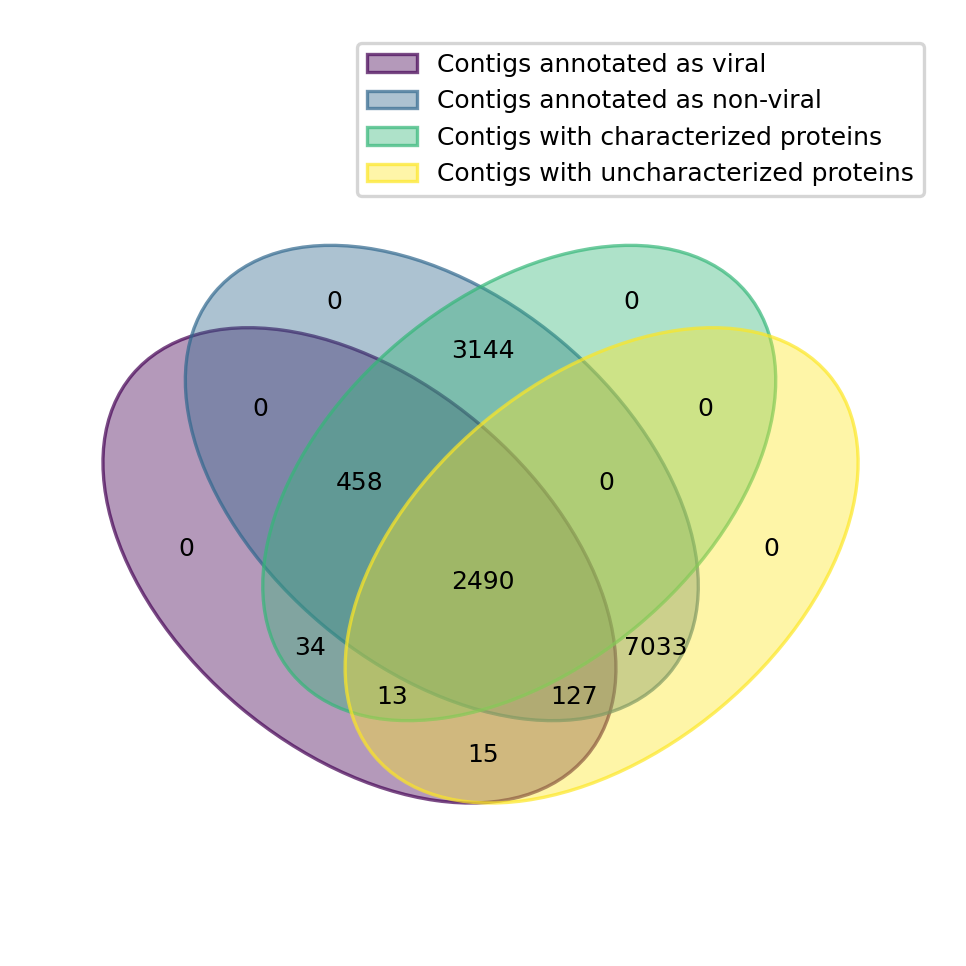

In [252]:
_, ax = plt.subplots(figsize = [5, 4], dpi = 300)
venn(myD, ax = ax, fontsize = 6);

In [253]:
#sel_viral_data_evalue,
#sel_viral_data_evalue2,
#sel_nonviral_data_evalue[sel_nonviral_data_evalue.qseqid.isin(sel_viral_data_evalue.qseqid)]
dst2 = pd.concat([sel_viral_data_evalue, sel_nonviral_data_evalue])

In [254]:
myD = {'Contigs annotated as viral':set(sel_viral_data_evalue.qseqid),
       'Contigs annotated as non-viral':set(sel_nonviral_data_evalue.qseqid),
       'Contigs with characterized proteins' : set( dst2.qseqid[~dst2.title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True)] ),
       'Contigs with uncharacterized proteins' : set ( dst2.qseqid[dst2.title.str.contains(
    'unnamed|uncharacterized|unknown|hypothetical',
    case = False, regex = True)]) }

<AxesSubplot:>

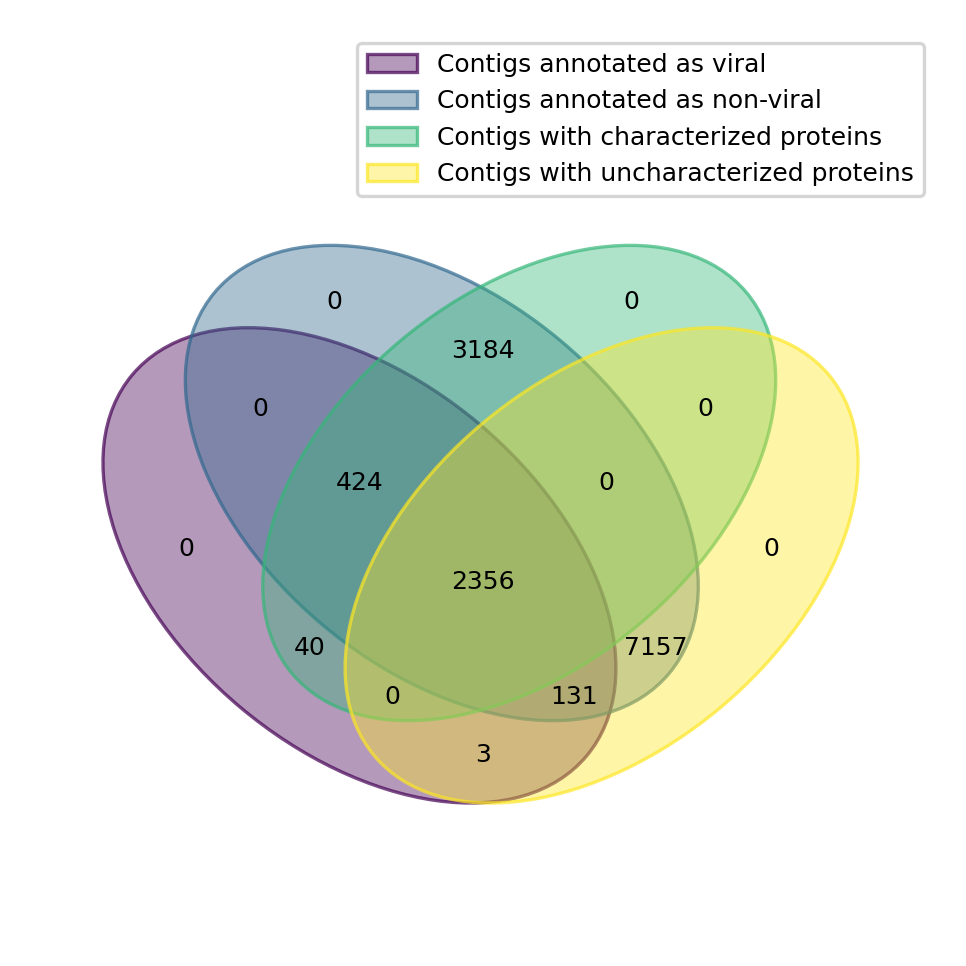

In [255]:
_, ax = plt.subplots(figsize = [5, 4], dpi = 300)
venn(myD, ax = ax, fontsize = 6)

In [258]:
session_info.show(excludes = ['pyarrow','distributed'])